In [ ]:
import numpy as np 
import xarray as xr 
import pandas as pd
from glob import glob
from tqdm import tqdm
import geopandas as gpd
import matplotlib as mpl
import cartopy.crs as ccrs
from rasterio.mask import mask
import matplotlib.pyplot as plt 
from collections import OrderedDict
from shapely.geometry import mapping
from scipy.signal import correlate2d
from cartopy import feature as cfeature

In [1]:
import os
os.environ['USE_PYGEOS'] = '0'
import sys
sys.path.append("/home/lcesarini/2022_resilience/")

sys.path.append("/mnt/data/lcesarini/SkillMetrics/")
import skill_metrics as sm

import rasterio
import argparse
import subprocess
# import rioxarray
import numpy as np 
import xarray as xr 
import pandas as pd
from glob import glob
from tqdm import tqdm
import geopandas as gpd
import matplotlib as mpl
import cartopy.crs as ccrs
from rasterio.mask import mask
import matplotlib.pyplot as plt 
from collections import OrderedDict
from shapely.geometry import mapping
from scipy.signal import correlate2d
from cartopy import feature as cfeature

os.chdir("/home/lcesarini/2022_resilience/")

from resilience.utils import *

ModuleNotFoundError: No module named 'skill_metrics'

In [3]:
cmap_test=mpl.colors.ListedColormap(['#7E1104',
                                    '#E33434', 
                                    '#F58080', 
                                    '#F8BCBC', 
                                    '#FBE2E2', 
                                    'white',
                                    '#D4F7FA',
                                    '#90DEF8',
                                    '#7BB2ED',
                                    '#262BBD',
                                    '#040880'
                                        ])
type(cmap_test)

matplotlib.colors.ListedColormap

In [8]:
dir(mpl.colorbar.collections)

['AsteriskPolygonCollection',
 'BrokenBarHCollection',
 'CapStyle',
 'CircleCollection',
 'Collection',
 'EllipseCollection',
 'EventCollection',
 'JoinStyle',
 'LineCollection',
 'Number',
 'PatchCollection',
 'PathCollection',
 'PolyCollection',
 'QuadMesh',
 'RegularPolyCollection',
 'StarPolygonCollection',
 'TriMesh',
 '_CollectionWithSizes',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 '_api',
 '_docstring',
 '_path',
 'artist',
 'cbook',
 'cm',
 'inspect',
 'math',
 'mcolors',
 'mhatch',
 'mlines',
 'mpath',
 'mpl',
 'np',
 'transforms',
 'warnings']

Text(0, 0.5, '[mm/hr]')

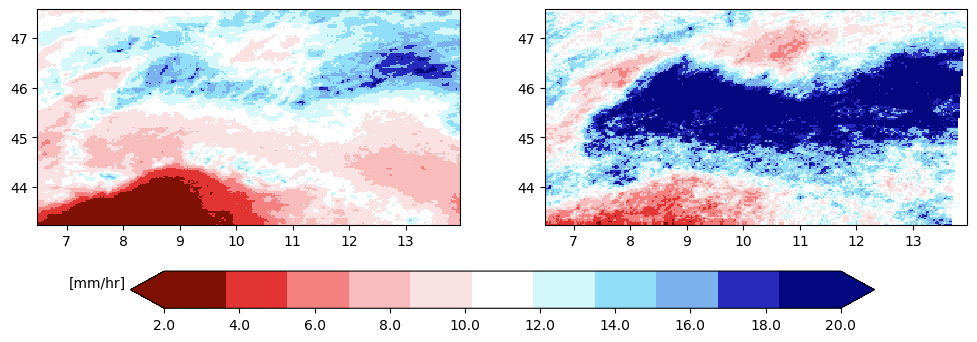

In [40]:
PATH_SPHERA_OUT="/mnt/data/RESTRICTED/CARIPARO/DATA_FPS/reanalysis/SPHERA/pr"
PATH_COMMON_DATA="/mnt/data/RESTRICTED/CARIPARO/DATA_FPS/ECMWF-ERAINT"
PATH_OUTPUT=f"/home/lcesarini/2022_resilience/output/"

pred=xr.open_dataset(f"{PATH_OUTPUT}/JJA/ENSEMBLE_q.nc").pr.values
ref=xr.open_dataset(f"{PATH_OUTPUT}/JJA/SPHERA_q.nc").pr.values


# if ax is None:
#     ax = plt.gca()

# if cbar_kw is None:
#     cbar_kw = {}

# # Plot the heatmap
# im = ax.imshow(data, **kwargs)


# qrates = list(data.reshape(-1))
# norm = mpl.colors.BoundaryNorm(np.linspace(-25, 25, 11), 10)
# fmt = mpl.ticker.FuncFormatter(lambda x, pos: qrates[::-1][norm(x)])


# im, _ = heatmap(data, y, x, ax=ax,
#                 cmap=(colors.ListedColormap(['#7E1104',
#                                     '#E33434', 
#                                     '#F58080', 
#                                     '#F8BCBC', 
#                                     '#FBE2E2', 
#                                     'white',
#                                     '#D4F7FA',
#                                     '#90DEF8',
#                                     '#7BB2ED',
#                                     '#262BBD',
#                                     '#040880'
#                                         ])), norm=norm,
#                 cbar_kw=dict(
#                             # ticks=np.arange(-3, 4), 
#                              format="{x:.1f}"),
#                 cbarlabel="Relative Bias [%]")


#plot pred e ref on two subplots (1 row, 2 columns)
fig,axs=plt.subplots(1,2,figsize=(12,4))
im0=xr.open_dataset(f"{PATH_OUTPUT}/JJA/ENSEMBLE_q.nc").pr.plot.pcolormesh(ax=axs[0],
                                                                           add_colorbar=False,
                                                                           cmap=cmap_test,
                                                                           norm=mpl.colors.Normalize(vmin=2,vmax=20)
                                                                           )
im1=xr.open_dataset(f"{PATH_OUTPUT}/JJA/SPHERA_q.nc").pr.plot.pcolormesh(ax=axs[1],
                                                                         add_colorbar=False,
                                                                         norm=mpl.colors.Normalize(vmin=2,vmax=20),
                                                                         cmap=cmap_test)
[axs[_].set_title("") for _ in range(2)]
[axs[_].set_xlabel("") for _ in range(2)]
[axs[_].set_ylabel("") for _ in range(2)]
# Create colorbar
cbar1 = fig.colorbar(im0, ax=axs, #cbar_kw=dict(
                            # ticks=np.arange(-3, 4), 
                            orientation='horizontal',
                            extend='both',
                            shrink=0.8,pad=0.15,
                            format="{x:.1f}")
# cbar2 = axs[1].figure.colorbar(im1, ax=axs[1], #cbar_kw=dict(
#                             # ticks=np.arange(-3, 4), 
#                             extend='both',
#                             format="{x:.1f}")
cbar1.ax.set_ylabel("[mm/hr]", rotation=0, va="bottom",labelpad=45)
# cbar2.ax.set_ylabel("prr", rotation=-90, va="bottom")

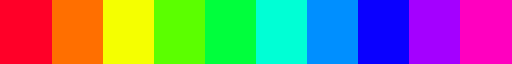

In [3]:

shp_triveneto = gpd.read_file("data/gadm36_ITA.gpkg", layer="gadm36_ITA_1")
shp_triveneto = shp_triveneto[np.isin(shp_triveneto.NAME_1,["Veneto","Trentino-Alto Adige"])]

shp_ita=gpd.read_file("/home/lcesarini/2022_resilience/gadm36_ITA.gpkg", layer="gadm36_ITA_0")
mask=xr.open_dataset("data/mask_stations_nan_common.nc")

M='q'
SEAS='JJA'

na_stat=xr.load_dataset(f"{PATH_OUTPUT}/JJA/STATIONS_q.nc").isel(quantile=0)

xmin,xmax=get_range(na_stat.lon)
ymin,ymax=get_range(na_stat.lat)

sdev=[]
crmsd=[]
ccoef=[]
M='q'
for idx,SEAS in enumerate(["DJF","MAM","JJA","SON"]):
    pred=xr.open_dataset(f"{PATH_OUTPUT}/{SEAS}/ENSEMBLE_{M}.nc").pr.values
    ref=xr.open_dataset(f"{PATH_OUTPUT}/{SEAS}/SPHERA_{M}.nc").pr.values
    sta=xr.load_dataset(f"{PATH_OUTPUT}/{SEAS}/STATIONS_{M}.nc").isel(quantile=0).pr.values
    
    if idx ==0:
        sdev.append(np.nanstd(ref))
        crmsd.append(sm.centered_rms_dev(ref,ref))
        ccoef.append(pattern_correlation(ref,ref))
    sdev.append(np.nanstd(pred))
    crmsd.append(sm.centered_rms_dev(pred,ref))
    ccoef.append(pattern_correlation(pred,ref))

    ens_sta = clip_ds(xr.open_dataset(f"{PATH_OUTPUT}/{SEAS}/ENSEMBLE_{M}.nc") * mask.mask,xmin,xmax,ymin,ymax)
    sph_sta = clip_ds(xr.open_dataset(f"{PATH_OUTPUT}/{SEAS}/SPHERA_{M}.nc") * mask.mask,xmin,xmax,ymin,ymax)
    # sph_sta = clip_ds(rea * mask.mask,xmin,xmax,ymin,ymax)

    sdev.append(np.nanstd(ens_sta.pr.values))
    crmsd.append(sm.centered_rms_dev(ens_sta.pr.values,sta))
    ccoef.append(pattern_correlation(ens_sta.pr.values,sta))

    sdev.append(np.nanstd(sph_sta.pr.values))
    crmsd.append(sm.centered_rms_dev(sph_sta.pr.values,sta))
    ccoef.append(pattern_correlation(sph_sta.pr.values,sta))


In [ ]:
label = ["Reference",
         "DJF_SPHERA",
         "DJF_STA",
         "DJF_STA_SPHERA",
         "MAM_SPHERA",
         "MAM_STA",
         "MAM_STA_SPHERA",
         "JJA_SPHERA",
         "JJA_STA",
         "JJA_STA_SPHERA",
         "SON_SPHERA",
         "SON_STA",
         "SON_STA_SPHERA"
         ]


In [45]:
MARKERS = {
        "Reference": {
            "labelColor": "k",
            "symbol": "+",
            "size": 9,
            "faceColor": "r",
            "edgeColor": "r",
        },
        "DJF_SPHERA": {
            "labelColor": "gray",
            "symbol": ".",
            "size": 9,
            "faceColor": "b",
            "edgeColor": "b",
        },
        "DJF_STA": {
            "labelColor": "k",
            "symbol": "x",
            "size": 9,
            "faceColor": "g",
            "edgeColor": "g",
        },
        "DJF_STA_SPHERA": {
            "labelColor": "gray",
            "symbol": "s",
            "size": 9,
            "faceColor": "r",
            "edgeColor": "r",
        },
        "MAM_SPHERA": {
            "labelColor": "k",
            "symbol": "d",
            "size": 9,
            "faceColor": "b",
            "edgeColor": "b",
        },
        "MAM_STA": {
            "labelColor": "gray",
            "symbol": "^",
            "size": 9,
            "faceColor": "g",
            "edgeColor": "g",
        },
        "MAM_STA_SPHERA": {
            "labelColor": "k",
            "symbol": "v",
            "size": 9,
            "faceColor": "r",
            "edgeColor": "r",
        },
        "JJA_SPHERA": {
            "labelColor": "gray",
            "symbol": "p",
            "size": 9,
            "faceColor": "b",
            "edgeColor": "b",
        },
        "JJA_STA": {
            "labelColor": "k",
            "symbol": "h",
            "size": 9,
            "faceColor": "g",
            "edgeColor": "g",
        },
        "JJA_STA_SPHERA": {
            "labelColor": "gray",
            "symbol": "*",
            "size": 9,
            "faceColor": "r",
            "edgeColor": "r",
        },
        "SON_SPHERA": {
            "labelColor": "k",
            "symbol": "+",
            "size": 9,
            "faceColor": "b",
            "edgeColor": "b",
        },
        "SON_STA": {
            "labelColor": "gray",
            "symbol": ".",
            "size": 9,
            "faceColor": "g",
            "edgeColor": "g",
        },
        "SON_STA_SPHERA": {
            "labelColor": "k",
            "symbol": "x",
            "size": 9,
            "faceColor": "m",
            "edgeColor": "m",
        },

}

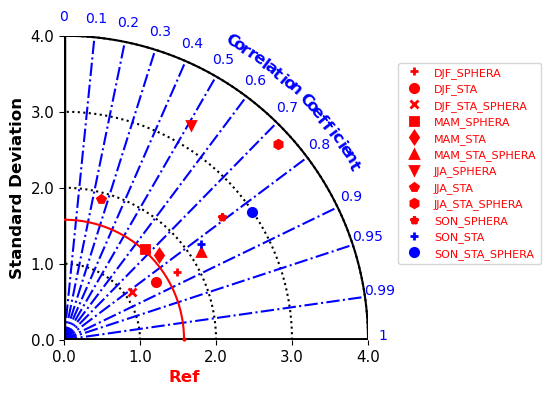

In [46]:
sm.taylor_diagram(
                    np.array(sdev),
                  np.array(crmsd),
                  np.array(ccoef), markerLabel = label, markerLabelColor = 'r', 
                    markerLegend = 'on', markerColor = 'r',
                    styleOBS = '-', colOBS = 'r', markerobs = 'o',
                    markerSize = 6, tickRMS = [0.0],
                    tickRMSangle = 115, showlabelsRMS = 'off',
                    titleRMS = 'off', titleOBS = 'Ref')

Text(0.5, 0.98, 'Heavy Prec 99.9th percentile')

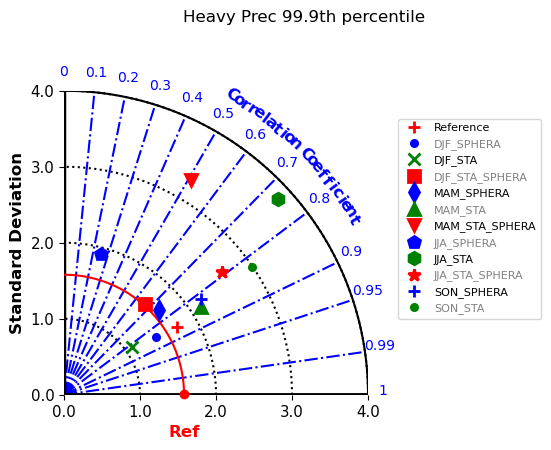

In [47]:
sm.taylor_diagram(np.array(sdev),
                  np.array(crmsd),
                  np.array(ccoef),
                    markers = MARKERS, 
                    markerLegend = 'on', styleOBS = '-', colOBS = 'r', markerobs = 'o',
                    tickRMS = [0.0],
                    tickRMSangle = 115, showlabelsRMS = 'off',
                    titleRMS = 'off', titleOBS = 'Ref')
plt.suptitle("Heavy Prec 99.9th percentile")

In [55]:
import argparse
import matplotlib.lines as mlines
import matplotlib.pyplot as plt
import skill_metrics as sm
import numpy as np

# ## DATA ####################################################################### #

LEGEND_SUBPLOT = (1, 2)

SUBPLOTS_DATA = [
    {
        "axis_idx": (0, 0),
        "title": "(a) 1 hour lead time",
        "y_label": True,
        "x_label": False,
        "observed": (29.91, 0.00, 1.00),
        "modeled": {
            "Model \u03B1": (30.28, 16.84, 0.84),
            "Model \u03B2": (28.54,  8.83, 0.96),
            "Model \u03B4": (28.02,  9.02, 0.95),
            "Model \u03B8": (28.51,  8.44, 0.96),
            "Model \u03C1": (28.39,  8.47, 0.96)
        }
    }, {
        "axis_idx": (0, 1),
        "title": "(b) 2 hours lead time",
        "y_label": False,
        "x_label": False,
        "observed": (29.91, 0.00, 1.00),
        "modeled": {
            "Model \u03B1": (25.45, 17.58, 0.81),
            "Model \u03B2": (26.07, 14.69, 0.87),
            "Model \u03B4": (24.57, 16.08, 0.84),
            "Model \u03B8": (26.43, 15.26, 0.86),
            "Model \u03C1": (26.57, 13.61, 0.89)
        }
    }, {
        "axis_idx": (0, 2),
        "title": "(c) 3 hours lead time",
        "y_label": False,
        "x_label": True,
        "observed": (29.91, 0.00, 1.00),
        "modeled": {
            "Model \u03B1": (19.37, 23.33, 0.64),
            "Model \u03B2": (21.98, 21.00, 0.72),
            "Model \u03B4": (20.02, 21.74, 0.70),
            "Model \u03B8": (22.46, 20.37, 0.74),
            "Model \u03C1": (23.32, 19.30, 0.77)
        }
    }, {
        "axis_idx": (1, 0),
        "title": "(d) 4 hours lead time",
        "y_label": True,
        "x_label": True,
        "observed": (29.91, 0.00, 1.00),
        "modeled": {
            "Model \u03B1": (15.46, 27.45, 0.46),
            "Model \u03B2": (16.64, 25.49, 0.56),
            "Model \u03B4": (14.74, 25.94, 0.54),
            "Model \u03B8": (19.71, 25.73, 0.56),
            "Model \u03C1": (19.30, 23.28, 0.66)
        }
    }, {
        "axis_idx": (1, 1),
        "title": "(e) 5 hours lead time",
        "y_label": True,
        "x_label": True,
        "observed": (29.91, 0.00, 1.00),
        "modeled": {
            "Model \u03B1": (10.33, 30.00, 0.28),
            "Model \u03B2": (16.54, 30.09, 0.33),
            "Model \u03B4": (12.03, 28.26, 0.43),
            "Model \u03B8": (15.76, 29.92, 0.34),
            "Model \u03C1": (15.87, 27.06, 0.50)
        }
    }
]

MARKERS = {
    "Observed": {
        "marker": "^",
        "color_edge": "#000000",
        "color_face": "#000000",
        "markersize": 9
    },
    "Model \u03B1": {
        "marker": "o",
        "color_edge": "#000000",
        "color_face": "#777777",
        "markersize": 9
    },
    "Model \u03B2": {
        "marker": "D",
        "color_edge": "#AA0000",
        "color_face": "#DD3333",
        "markersize": 9
    },
    "Model \u03B4": {
        "marker": "v",
        "color_edge": "#00AA00",
        "color_face": "#33DD33",
        "markersize": 9
    },
    "Model \u03B8": {
        "marker": "+",
        "color_edge": "#0000AA",
        "color_face": "#3333DD",
        "markersize": 9
    },
    "Model \u03C1": {
        "marker": "*",
        "color_edge": "#D4AF37",
        "color_face": "#FFD700",
        "markersize": 12
    }
}




findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

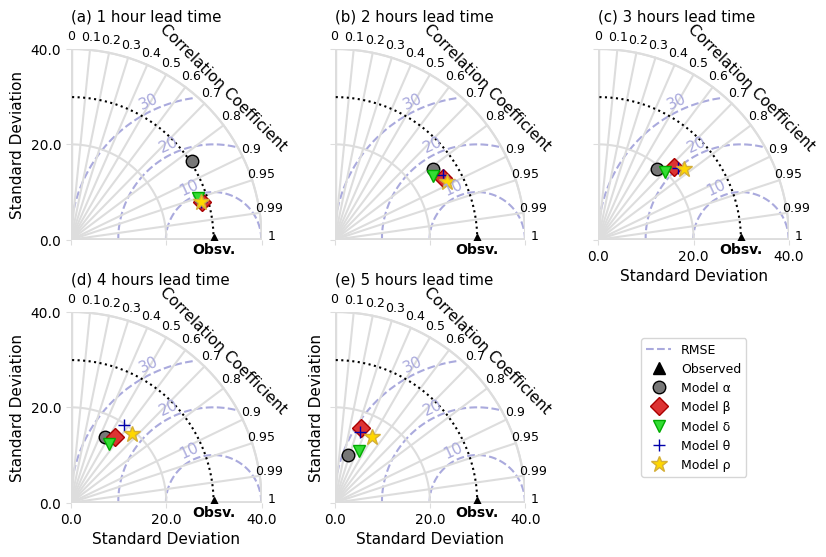

In [56]:
# ## PLOT STYLE ################################################################# #

FONT_FAMILY = 'Times New Roman'
FONT_SIZE = 9

# specify some styles for the correlation component
COLS_COR = {
    'grid': '#DDDDDD',
    'tick_labels': '#000000',
    'title': '#000000'
}

# specify some styles for the standard deviation
COLS_STD = {
    'grid': '#DDDDDD',
    'tick_labels': '#000000',
    'ticks': '#DDDDDD',
    'title': '#000000'
}

# specify some styles for the root mean square deviation
STYLES_RMS = {
    'color': '#AAAADD',
    'linestyle': '--'
}


# ## CONSTANTS ################################################################## #

OUTPUT_FILE_PATH = "taylor14.png"

# ## MAIN ####################################################################### #


# Close any previously open graphics windows
# ToDo: fails to work within Eclipse
plt.close('all')

# update figures global properties
plt.rcParams.update({'font.size': FONT_SIZE, 'font.family': FONT_FAMILY})

# create figure with 2 lines and 3 columns
fig_size = (3*2.8, 2*2.8)
fig, axs = plt.subplots(2, 3, figsize=fig_size, sharey=True)
del fig_size

# build subplot by subplot
for subplot_data in SUBPLOTS_DATA:
    
    # get subplot object and ensure it will be a square
    # y-axis labels will only appear on leftmost subplot
    ax = axs[subplot_data["axis_idx"][0]][subplot_data["axis_idx"][1]]
    ax.set(adjustable='box', aspect='equal')

    # create the plot with the observed data
    stdev, crmsd, ccoef = subplot_data["observed"]
    sm.taylor_diagram(ax,
                        np.asarray((stdev, stdev)), 
                        np.asarray((crmsd, crmsd)), 
                        np.asarray((ccoef, ccoef)),
                        markercolors = {
                            "face": MARKERS["Observed"]["color_edge"],
                            "edge": MARKERS["Observed"]["color_face"]
                            },
                        markersize = MARKERS["Observed"]["markersize"],
                        markersymbol = MARKERS["Observed"]["marker"],
                        styleOBS = ':',
                        colOBS = MARKERS["Observed"]["color_edge"],
                        alpha = 1.0,
                        titleSTD = 'off',
                        titleRMS = 'off',
                        showlabelsRMS = 'on',
                        tickRMS = [10, 20, 30],
                        colRMS = STYLES_RMS['color'],
                        tickRMSangle = 115,
                        styleRMS = STYLES_RMS['linestyle'],
                        colscor = COLS_COR,
                        colsstd = COLS_STD,
                        styleCOR='-',
                        styleSTD='-',
                        colframe='#DDDDDD',
                        labelweight='normal',
                        titlecorshape='linear')

    # add label below the marker
    ax.text(stdev, -0.5, "Obsv.", verticalalignment="top",
            horizontalalignment="center", 
            fontsize=FONT_SIZE+1, fontweight="bold")
    
    # get rid of variables not to be used anymore
    del stdev, crmsd, ccoef

    # create one overlay for each model marker
    for model_id, (stdev, crmsd, ccoef) in subplot_data["modeled"].items():
        marker = MARKERS[model_id]
        sm.taylor_diagram(ax,
                            np.asarray((stdev, stdev)),
                            np.asarray((crmsd, crmsd)),
                            np.asarray((ccoef, ccoef)),
                            markersymbol = marker["marker"],
                            markercolors = {
                            "face": marker["color_face"],
                            "edge": marker["color_edge"]
                            },
                            markersize = marker["markersize"],
                            alpha = 1.0,
                            overlay = 'on',
                            styleCOR = '-',
                            styleSTD = '-')

        # get rid of variables not to be used anymore
        del model_id, stdev, crmsd, ccoef, marker

    # set titles (upper, left, bottom)
    ax.set_title(subplot_data["title"], loc="left", y=1.1)

    # add y label
    if subplot_data["y_label"]:
        ax.set_ylabel("Standard Deviation", fontfamily=FONT_FAMILY,
                        fontsize=FONT_SIZE+2)

    # add xlabel or hide xticklabels
    if subplot_data["x_label"]:
        ax.set_xlabel("Standard Deviation", fontfamily=FONT_FAMILY,
                        fontsize=FONT_SIZE+2)
    else:
        ax.set_xticklabels(ax.get_xticklabels(), color=ax.get_facecolor())

    # just for the peace of mind...
    del subplot_data, ax

# create legend in the last subplot
ax = axs[LEGEND_SUBPLOT[0]][LEGEND_SUBPLOT[1]]
ax.axis('off')

# build legend handles    
legend_handles = []
legend_handles.append(mlines.Line2D([], [],
                        color=STYLES_RMS['color'],
                        linestyle=STYLES_RMS['linestyle'],
                        label="RMSE"))

for marker_label, marker_desc in MARKERS.items():
    marker = mlines.Line2D([], [], 
                            marker=marker_desc["marker"],
                            markersize=marker_desc["markersize"],
                            markerfacecolor=marker_desc["color_face"],
                            markeredgecolor=marker_desc["color_edge"],
                            linestyle='None',
                            label=marker_label)
    legend_handles.append(marker)
    del marker_label, marker_desc, marker

# create legend and free memory
ax.legend(handles=legend_handles, loc="center")    
del ax, legend_handles

# avoid some overlapping
plt.tight_layout()




/tmp/ipykernel_1449000/22403306.py:35: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = fig.colorbar(scalarMap, ticks=bounds, boundaries=bounds, format='%.2f')


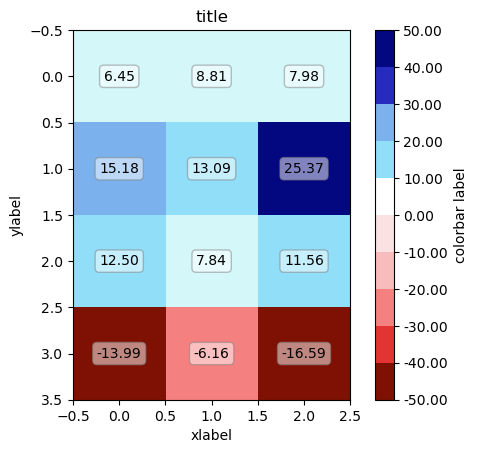

In [22]:
#make an heatmap with a discrete colorbar
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.colorbar as colorbar

#data
data = np.loadtxt(f"/home/lcesarini/2022_resilience/output/array_heatmap_pr.txt")


#plot
fig, ax = plt.subplots()
cmap = (colors.ListedColormap(['#7E1104',
                                    '#E33434', 
                                    '#F58080', 
                                    '#F8BCBC', 
                                    '#FBE2E2', 
                                    'white',
                                    '#D4F7FA',
                                    '#90DEF8',
                                    '#7BB2ED',
                                    '#262BBD',
                                    '#040880'
                                        ]))# cNorm = colors.Normalize(vmin=0, vmax=1)
scalarMap = cmx.ScalarMappable(norm=colors.Normalize(vmin=-50,vmax=51),cmap=cmap)
ax.imshow(data, interpolation='nearest', cmap=cmap)
ax.set_title('title')
ax.set_xlabel('xlabel')
ax.set_ylabel('ylabel')
# ax.grid(True)
#colorbar
#make the colorbar discrete
bounds = np.arange(-50,51,10)
cbar = fig.colorbar(scalarMap, ticks=bounds, boundaries=bounds, format='%.2f')

cbar.set_label('colorbar label')

#write the number of each cell
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        ax.text(j, i, '%.2f' % data[i, j],
                ha='center', va='center',
                bbox=dict(boxstyle='round', facecolor='white', alpha=0.5, ec='grey'))

plt.show()


In [31]:
def heatmap(data, row_labels, col_labels, ax=None,
            cbar_kw=None, cbarlabel="", **kwargs):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if ax is None:
        ax = plt.gca()

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    return im, cbar


def annotate_heatmap(im, data=None, valfmt="{x:.2f}",
                     textcolors=("black", "white"),
                     threshold=None, **textkw):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
        separation.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    if not isinstance(data, (list, np.ndarray)):
        data = im.get_array()

    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = mpl.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)

    return texts

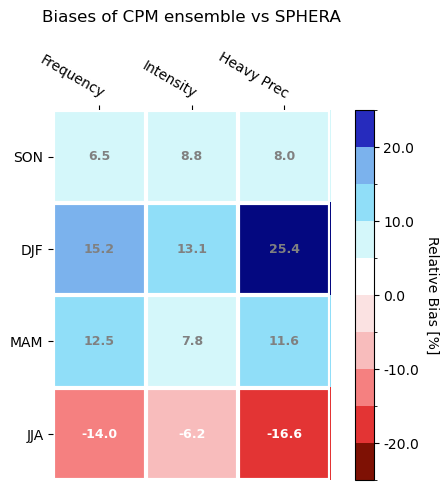

In [64]:
import matplotlib as mpl

ax=plt.axes()

data = np.loadtxt(f"/home/lcesarini/2022_resilience/output/array_heatmap_pr.txt")

y = ["SON","DJF","MAM","JJA"]
x = ["Frequency","Intensity","Heavy Prec"]

qrates = list(data.reshape(-1))
norm = mpl.colors.BoundaryNorm(np.linspace(-25, 25, 11), 10)
fmt = mpl.ticker.FuncFormatter(lambda x, pos: qrates[::-1][norm(x)])


im, _ = heatmap(data, y, x, ax=ax,
                cmap=(colors.ListedColormap(['#7E1104',
                                    '#E33434', 
                                    '#F58080', 
                                    '#F8BCBC', 
                                    '#FBE2E2', 
                                    'white',
                                    '#D4F7FA',
                                    '#90DEF8',
                                    '#7BB2ED',
                                    '#262BBD',
                                    '#040880'
                                        ])), norm=norm,
                cbar_kw=dict(
                            # ticks=np.arange(-3, 4), 
                             format="{x:.1f}"),
                cbarlabel="Relative Bias [%]")

annotate_heatmap(im, data=data,valfmt="{x:.1f}", size=9, fontweight="bold", threshold=-1,
                 textcolors=("white", "grey"));
ax.set_title("Biases of CPM ensemble vs SPHERA",pad=20);

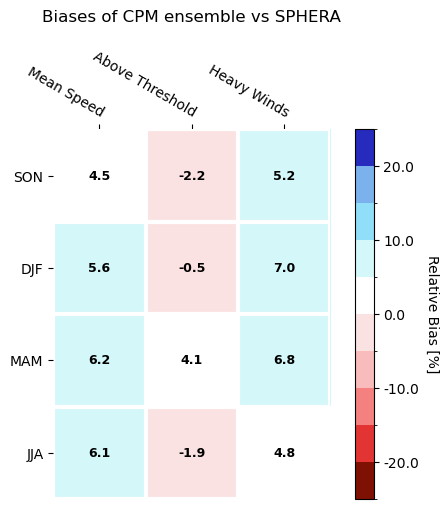

In [61]:
import matplotlib as mpl

ax=plt.axes()

data = np.loadtxt(f"/home/lcesarini/2022_resilience/output/array_heatmap_wind.txt")

y = ["SON","DJF","MAM","JJA"]
x = ["Mean Speed","Above Threshold","Heavy Winds"]

qrates = list(data.reshape(-1))
norm = mpl.colors.BoundaryNorm(np.linspace(-25, 25, 11), 10)
fmt = mpl.ticker.FuncFormatter(lambda x, pos: qrates[::-1][norm(x)])


im, _ = heatmap(data, y, x, ax=ax,
                cmap=(colors.ListedColormap(['#7E1104',
                                    '#E33434', 
                                    '#F58080', 
                                    '#F8BCBC', 
                                    '#FBE2E2', 
                                    'white',
                                    '#D4F7FA',
                                    '#90DEF8',
                                    '#7BB2ED',
                                    '#262BBD',
                                    '#040880'
                                        ])), norm=norm,
                cbar_kw=dict(
                            # ticks=np.arange(-3, 4), 
                             format="{x:.1f}"),
                cbarlabel="Relative Bias [%]")

annotate_heatmap(im, data=data,valfmt="{x:.1f}", size=9, fontweight="bold", threshold=-1,
                 textcolors=("black", "black"));
ax.set_title("Biases of CPM ensemble vs SPHERA",pad=20);

IndexError: list index out of range

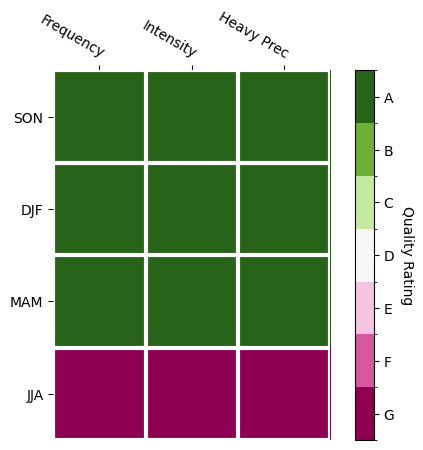

In [85]:
import os
os.environ['USE_PYGEOS'] = '0'
import sys
sys.path.append("/home/lcesarini/2022_resilience/")

import os
import rioxarray
import numpy as np 
import xarray as xr 
import pandas as pd
import seaborn as sns
from glob import glob
from tqdm import tqdm
import geopandas as gpd
import cartopy.crs as ccrs
import matplotlib as mpl
import matplotlib.pyplot as plt 
from cartopy import feature as cfeature

from resilience.utils.retrieve_data import get_unlist

import warnings
warnings.filterwarnings('ignore')

os.chdir("/home/lcesarini/2022_resilience/")
def plot_panel_rotated(figsize,nrow,ncol,
                       list_to_plot,
                       name_fig,
                       list_titles='Any title',
                       levels=[9],
                       suptitle="Frequency for JJA",
                       name_metric=["Frequency"],
                       SET_EXTENT=True,
                       cmap=['rainbow'],
                       proj=ccrs.PlateCarree(),
                       transform=ccrs.PlateCarree(),
                       SAVE=True
                    ):
    """
    
    Plots panel of the given xarray datasets
    
    Parameters
    ----------
    list_to_plot : list, defaults to None
                  list of the dataarray to plot 
    name_fig: 

    list_titles: 

    levels: either an int indicating the number of intervals or a list of values to break to palette into.
    Returns
    -------



    Examples
        --------
    
    """
    fig,axs=plt.subplots(nrow,ncol,
                        figsize=figsize,constrained_layout=True, squeeze=True,
                        subplot_kw={"projection":proj})
    # Adjust the horizontal and vertical spacing between subplots
    plt.subplots_adjust(wspace=0, hspace=0.5)
    if (nrow > 1) or (ncol > 1):
        ax=axs.flatten()
    else:
        ax=axs


    for i,model in enumerate(list_to_plot):
        # if i in [0,1,2]:
        #     pcm=model.plot.\
        #         pcolormesh(x="lon",y="lat",ax=ax[i],
        #                    add_colorbar=False,
        #                 #    cbar_kwargs={"shrink":0.85},
        #                    levels=np.arange(0.04,0.28,0.03),
        #                    cmap="rainbow",
        #                    #norm=norm
        #                    )
        # else:
        if (nrow > 1) or (ncol > 1) :
            pcm=model.plot.pcolormesh(ax=ax[i],
                                    add_colorbar=False,
                                    #   cbar_kwargs={"shrink":0.85},
                                    levels=levels[i],
                                    cmap=cmap[i],#"rainbow",
                                    transform=transform                                    
                                    )

            # shp_triveneto.boundary.plot(ax=ax[i],edgecolor='red',transform=proj,linewidth=1)
            ax[i].add_feature(cfeature.BORDERS)
            ax[i].coastlines()
            if SET_EXTENT:
                ax[i].set_extent([10.2,13.15,44.6,47.15])
            # ax[i].set_title(f"{list_titles[i]}",bbox={'facecolor': 'white', 'alpha': 0.8, 'pad': 5})
            ax[i].text(0.5, 0.9, f"{list_titles[i]}", ha='center', va='center', bbox={'facecolor': 'white', 'alpha': 1, 'pad': 5})
            gl = ax[i].gridlines(
                draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',
            )
            gl.xlabels=False
            if i in np.arange(ncol*nrow-ncol,ncol*nrow):
                # cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
                cbar=fig.colorbar(pcm, ax=ax[i] if (nrow > 1) or (ncol > 1) else ax, 
                                    extend='neither', ticks=levels[i],boundaries=levels[i],
                                    orientation='horizontal',
                                    shrink=0.15)
                cbar.ax.tick_params(labelsize=10)
                cbar.ax.set_ylabel(name_metric[i],fontsize=10,rotation=0,loc='bottom',labelpad=40)
                ax[i].add_feature(cfeature.BORDERS)
                # ax[i].add_feature(cfeature.STATES)

        else:
            pcm=model.plot.pcolormesh(ax=ax,
                        add_colorbar=False,
                        #   cbar_kwargs={"shrink":0.85},
                        levels=levels[i],
                        cmap=cmap[i],#"rainbow",
                        transform=transform                                    
                        )

            shp_triveneto.boundary.plot(ax=ax,edgecolor='red')
            # ax.add_geometries(shp_triveneto['geometry'], crs=proj)
            ax.add_feature(cfeature.BORDERS)
            ax.coastlines()
            ax.set_title(f"{list_titles[i]}")
            gl = ax.gridlines(
                draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--'
            )
            if SET_EXTENT:
                ax.set_extent([10.2,13.15,44.6,47.15])

            gl.xlines=None
            gl.xlabels_top=None
            gl.xlabels_bottom=None

            # cbar=fig.colorbar(pcm, ax=ax, extend='both', orientation='horizontal')
            if i in [0,1,2]:
                cbar=fig.colorbar(pcm, ax=ax[i] if (nrow > 1) or (ncol > 1) else ax, 
                                    extend='both', 
                                    orientation='vertical',
                                    shrink=0.65)
                cbar.ax.tick_params(labelsize=30)
                cbar.ax.set_ylabel(name_metric[i],fontsize=10,rotation=0,loc='bottom')
    fig.suptitle(suptitle, fontsize=14)
    if SAVE:
        plt.savefig(f"/home/lcesarini/2022_resilience/figures/{name_fig}.png")
        plt.close()
    else:
        plt.show()

In [89]:
from resilience.utils import *

cmap_f,cmap_i,cmap_q=get_palettes()
lvl_f,lvl_i,lvl_q=get_levels()

name_models=[
    'MOHC','ETH','KIT','CMCC','ICTP','CNRM','KNMI','HCLIMcom',
    # "CMCC_VHR",
    "ENSEMBLE",
    # "STATIONS",
    "SPHERA"
    ]

"""
MAKE PAS OF QUANTILE 5x2
"""
SEAS="DJF"
ll_ds=[xr.open_dataset(f"output/{SEAS}/{nm}_q.nc").pr for nm in name_models]

In [90]:
!pwd

/home/lcesarini/2022_resilience


In [91]:
plot_panel_rotated(
    figsize=(20,6),
    nrow=2,ncol=5,
    list_to_plot=ll_ds,
    name_fig=f"PANEL_HP_{SEAS}",
    list_titles=name_models,
    levels=[np.linspace(2,26,9).astype(np.int16) for _ in name_models],
    suptitle=f"Heavy Precipitation 99.9th quantile for {SEAS}",
    name_metric=["[mm/hr]" for _ in name_models],
    SET_EXTENT=False,
    cmap=[cmap_q for _ in name_models],
    SAVE=True
)

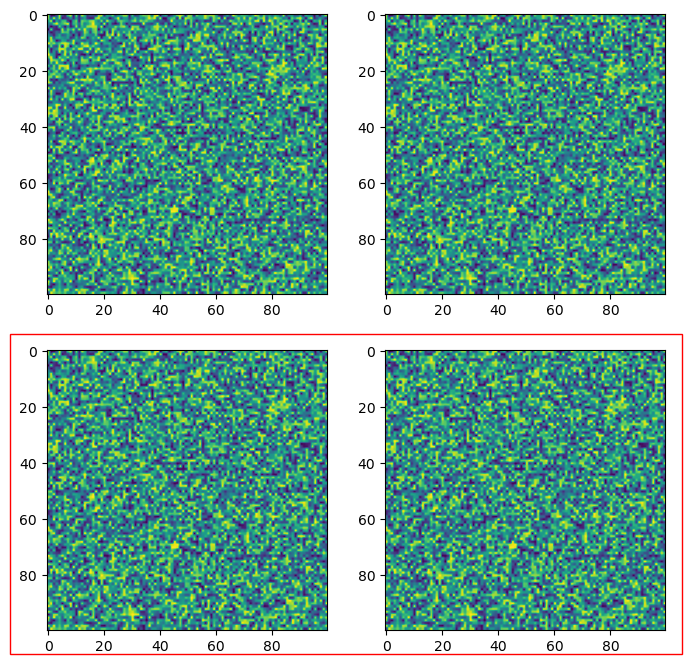

In [109]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Create a sample 2D array
data = np.random.random((100, 100))

# Create a figure and a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(8, 8))

# Plot the data in subplots 1 and 2
axs[0, 0].imshow(data, cmap='viridis')
axs[0, 1].imshow(data, cmap='viridis')

# Draw a rectangle covering subplots 1 and 2
rect = patches.Rectangle((0.08, 0.08), .84, .4, linewidth=1, edgecolor='r', facecolor='none', transform=fig.transFigure)
fig.patches.append(rect)

# Plot other subplots if needed
axs[1, 0].imshow(data, cmap='viridis')
axs[1, 1].imshow(data, cmap='viridis')

# Show the plot
plt.show()


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid.inset_locator import inset_axes
import cartopy.crs as ccrs
import cartopy.io.img_tiles as cimgt

import windrose

ws = np.random.random(500) * 6
wd = np.random.random(500) * 360

minlon, maxlon, minlat, maxlat = (6.5, 7.0, 45.85, 46.05)

proj = ccrs.PlateCarree()
fig = plt.figure(figsize=(12, 6))
# Draw main ax on top of which we will add windroses
main_ax = fig.add_subplot(1, 1, 1, projection=proj)
main_ax.set_extent([minlon, maxlon, minlat, maxlat], crs=proj)
main_ax.gridlines(draw_labels=True)
main_ax.coastlines()

request = cimgt.OSM()
main_ax.add_image(request, 12)

# Coordinates of the station we were measuring windspeed
cham_lon, cham_lat = (6.8599, 45.9259)
passy_lon, passy_lat = (6.7, 45.9159)

# Inset axe it with a fixed size
wrax_cham = inset_axes(main_ax,
        width=1,                             # size in inches
        height=1,                            # size in inches
        loc='center',                        # center bbox at given position
        bbox_to_anchor=(cham_lon, cham_lat), # position of the axe
        bbox_transform=main_ax.transData,    # use data coordinate (not axe coordinate)
        axes_class=windrose.WindroseAxes,    # specify the class of the axe
        )

# Inset axe with size relative to main axe
height_deg = 0.1
wrax_passy = inset_axes(main_ax,
        width="100%",                        # size in % of bbox
        height="100%",                       # size in % of bbox
        #loc='center',  # don't know why, but this doesn't work.
        # specify the center lon and lat of the plot, and size in degree
        bbox_to_anchor=(passy_lon-height_deg/2, passy_lat-height_deg/2, height_deg, height_deg),
        bbox_transform=main_ax.transData,
        axes_class=windrose.WindroseAxes,
        )

wrax_cham.bar(wd, ws)
wrax_passy.bar(wd, ws)
for ax in [wrax_cham, wrax_passy]:
  ax.tick_params(labelleft=False, labelbottom=False)

ModuleNotFoundError: No module named 'mpl_toolkits.axes_grid'

In [ ]:
import tensorflow as tf

# Check for available GPUs
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow is using the GPU.")
else:
    print("TensorFlow is not using the GPU.")


In [2]:
import os
os.environ['USE_PYGEOS'] = '0'
import argparse
import rioxarray
import numpy as np 
import xarray as xr 
import pandas as pd
import eccodes as ec
from glob import glob
from tqdm import tqdm
import geopandas as gpd
import matplotlib as mpl
from random import sample
import cartopy.crs as ccrs
import matplotlib.pyplot as plt 
from shapely.geometry import mapping
from cartopy import feature as cfeature
from math import pi,sin,cos, asin, atan2
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score,mean_absolute_percentage_error

# from utils import *

import warnings
warnings.filterwarnings('ignore')
PATH_COMMON_DATA="/mnt/data/RESTRICTED/CARIPARO/DATA_FPS/ECMWF-ERAINT"
path_model="/mnt/data/RESTRICTED/CARIPARO/datiDallan"

os.chdir("/home/lcesarini/2022_resilience/")

shp_triveneto = gpd.read_file("/home/lcesarini/2022_resilience/data/gadm36_ITA.gpkg", layer="gadm36_ITA_1")
shp_triveneto = shp_triveneto[np.isin(shp_triveneto.NAME_1,["Veneto","Trentino-Alto Adige"])]
    
import sys
sys.path.append("/home/lcesarini/2022_resilience/")

from resilience.utils import *

lvl_f,lvl_i,lvl_q=get_levels()
cmap_f,cmap_i,cmap_q=get_palettes()


In [8]:
grib_in=open("/mnt/data/lcesarini/COSMO/REA_2/TOT_PRECIP/TOT_PRECIP.2D.201806.grb",'rb')

In [14]:
count = 0
while 1:
    
    # Get a handle to the GRIB message
    gid = ec.codes_grib_new_from_file(grib_in)
    
    # Test if we've reached the end of file and 
    if gid is None:
        break

    count +=1

        # Get the parameter shortName, paramId and units:
    param_shortName = codes_get(gid,'shortName')
    param_pid = codes_get(gid,'paramId')
    param_units = codes_get(gid,'units')

In [ ]:
ncks -C -O -x -v initial_time0_encoded,initial_time0 /mnt/data/lcesarini/COSMO/REA_2/TOT_PRECIP/TOT_PRECIP.2D.201806.grb /mnt/data/lcesarini/tmp/test_cosmo3.grb

In [36]:
!grib_to_netcdf -o /mnt/data/lcesarini/tmp/test_cosmo2.nc /mnt/data/lcesarini/COSMO/REA_2/TOT_PRECIP/TOT_PRECIP.2D.201806.grb 

grib_to_netcdf: Version 2.28.0
grib_to_netcdf: Processing input file '/mnt/data/lcesarini/COSMO/REA_2/TOT_PRECIP/TOT_PRECIP.2D.201806.grb'.
grib_to_netcdf: Found 720 GRIB fields in 1 file.
grib_to_netcdf: Ignoring key(s): method, type, stream, refdate, hdate
grib_to_netcdf: Creating netCDF file '/mnt/data/lcesarini/tmp/test_cosmo2.nc'
grib_to_netcdf: NetCDF library version: 4.8.1 of Oct 31 2022 22:16:44 $
grib_to_netcdf: Creating large (64 bit) file format.
ECCODES ERROR   :  Grid type = rotated_ll
ECCODES ERROR   :  First GRIB is not on a regular lat/lon grid or on a regular Gaussian grid. Exiting.



In [ ]:
xr.open_dataset("/mnt/data/lcesarini/tmp/test_cosmo2.grb",engine='pynio')

In [11]:
cdo remapycon,/home/lcesarini/2022_resilience/resilience/scripts/newcommongrid.txt /mnt/data/lcesarini/COSMO/REA_2/TOT_PRECIP/TOT_PRECIP.2D.201806.grb /mnt/data/lcesarini/tmp/test_cosmo2.grb

Warning (cdfScanVarAttr): NetCDF: Variable not found - >step<
Warning (cdfScanVarAttr): NetCDF: Variable not found - >surface<
Warning (cdfScanVarAttr): NetCDF: Variable not found - >latitude<
Warning (cdfInqContents): Coordinates variable time can't be assigned!

cdo    remapcon (Abort): Unsupported generic coordinates (Variable: tp)!


In [15]:
cosmo=xr.open_dataset("/mnt/data/lcesarini/COSMO/REA_2/TOT_PRECIP/TOT_PRECIP.2D.201806.grb",engine='pynio')
cosmo


<xarray.Dataset>
Dimensions:                   (initial_time0_hours: 720, g10_x_1: 780,
                               g10_y_2: 724)
Coordinates:
  * initial_time0_hours       (initial_time0_hours) datetime64[ns] 2018-06-01...
    g10_lat_1                 (g10_x_1, g10_y_2) float32 ...
    g10_lon_2                 (g10_x_1, g10_y_2) float32 ...
Dimensions without coordinates: g10_x_1, g10_y_2
Data variables:
    TOT_PREC_GDS10_SFC_acc1h  (initial_time0_hours, g10_x_1, g10_y_2) float32 ...
    initial_time0_encoded     (initial_time0_hours) float64 ...
    g10_rot_3                 (g10_x_1, g10_y_2) float32 ...
    initial_time0             (initial_time0_hours) |S0 ...

In [19]:
cosmo.drop_vars(["initial_time0_encoded","initial_time0"]).to_netcdf("/mnt/data/lcesarini/tmp/prova.nc")


In [ ]:
cdo remapycon,/home/lcesarini/2022_resilience/resilience/scripts/newcommongrid.txt /mnt/data/lcesarini/tmp/prova.nc /mnt/data/lcesarini/tmp/test_cosmo2.grb

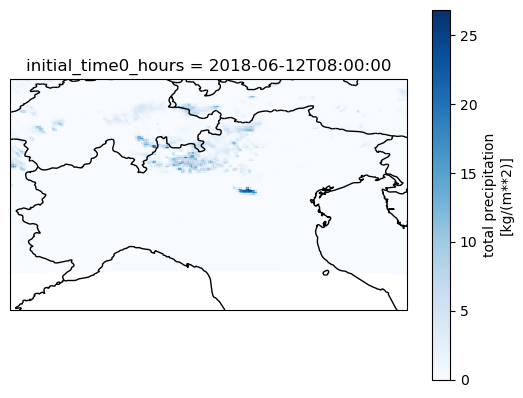

In [25]:
ax=plt.axes(projection=ccrs.PlateCarree())
cosmo.isel(initial_time0_hours=10).TOT_PREC_GDS0_SFC_acc116h.plot(cmap='Blues',ax=ax)
ax.coastlines()
ax.add_feature(cfeature.BORDERS)

In [ ]:
xr.open_dataset("/mnt/data/lcesarini/COSMO/REA_2/TOT_PRECIP/TOT_PRECIP.2D.201806.nc")

In [30]:
cosmo=xr.open_dataset("/mnt/data/lcesarini/COSMO/REA_2/TOT_PRECIP/TOT_PRECIP.2D.201806.nc")
cosmo


<xarray.Dataset>
Dimensions:     (time: 720, y: 780, x: 724)
Coordinates:
  * time        (time) datetime64[ns] 2018-06-01T01:00:00 ... 2018-07-01
    step        timedelta64[ns] ...
    surface     float64 ...
    latitude    (y, x) float64 ...
    longitude   (y, x) float64 ...
    valid_time  (time) datetime64[ns] ...
Dimensions without coordinates: y, x
Data variables:
    tp          (time, y, x) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             edzw
    GRIB_centreDescription:  Offenbach 
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Offenbach 
    history:                 2023-09-11T11:26 GRIB to CDM+CF via cfgrib-0.9.1...

In [28]:
cosmo.longitude.min().item(),cosmo.longitude.max().item()

(-3.85213, 20.241062)

In [4]:
cdo remapycon,/home/lcesarini/2022_resilience/resilience/scripts/newcommongrid.txt /mnt/data/lcesarini/COSMO/REA_2/TOT_PRECIP/TOT_PRECIP.2D.201806.nc /mnt/data/lcesarini/tmp/test_cosmo.nc

SyntaxError: invalid decimal literal (1335914261.py, line 1)

In [6]:
tas_eth=[xr.open_mfdataset(f"/mnt/data/RESTRICTED/CARIPARO/DATA_FPS/ECMWF-ERAINT/{mdl}/CPM/*sftlf*").load() for mdl in ["CMCC","CNRM","HCLIMcom","ICTP","KIT","KNMI"]]
merge_oro=xr.concat(tas_eth,dim="model")

In [8]:
merge_oro['model'] = ["CMCC","CNRM","HCLIMcom","ICTP","KIT","KNMI"]

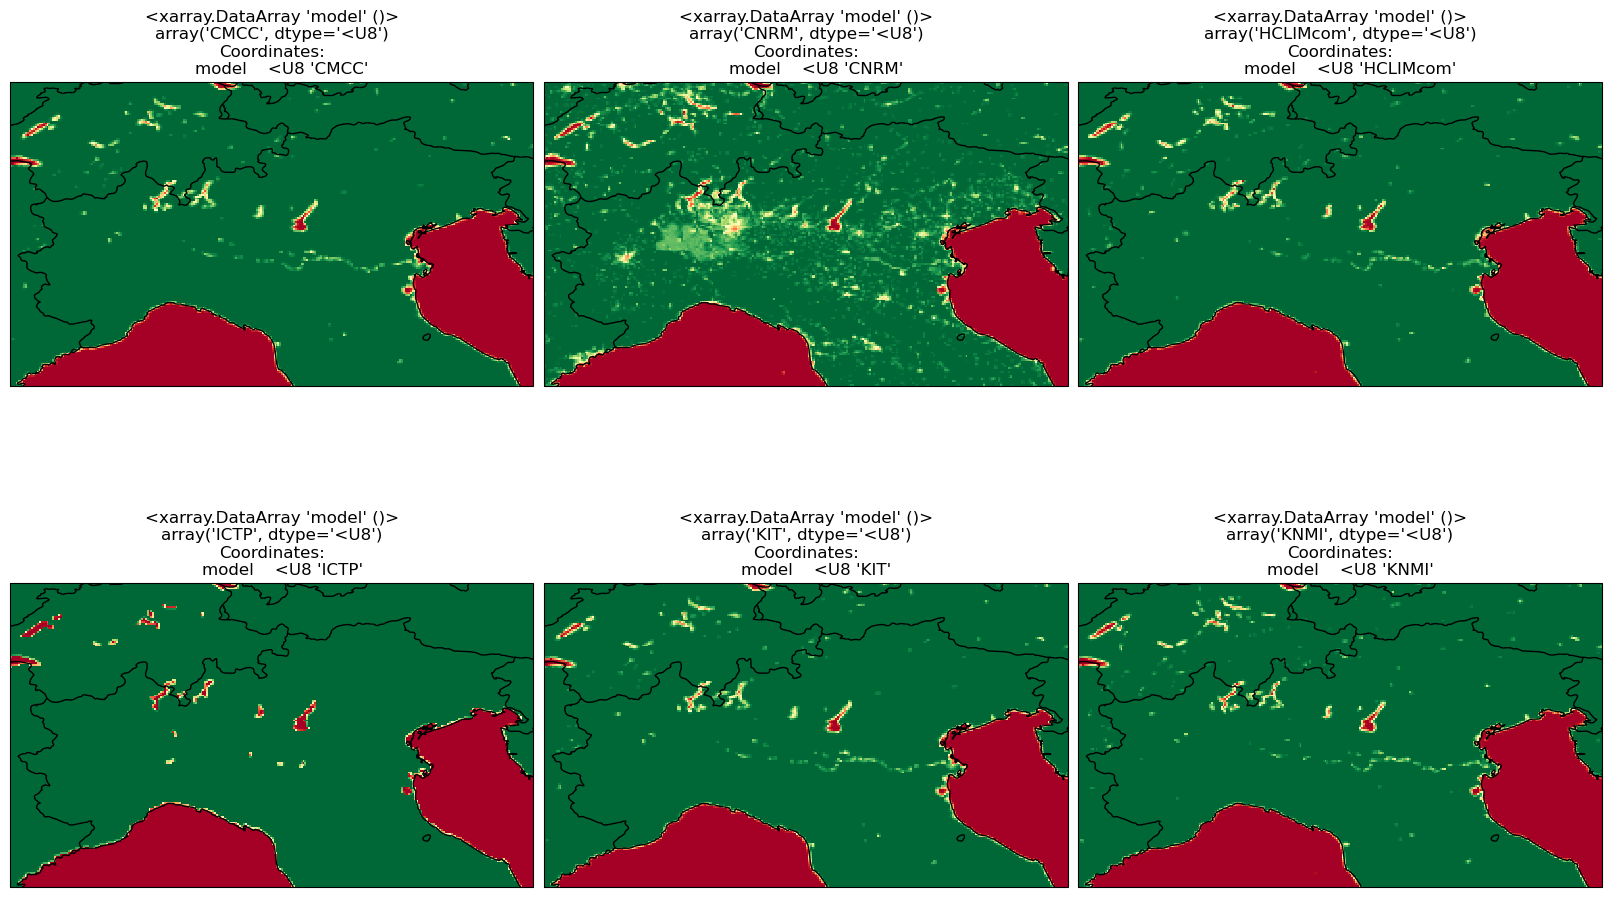

In [ ]:
fig,ax=plt.subplots(2,3,figsize=(16,10),subplot_kw={"projection":ccrs.PlateCarree()},constrained_layout=True, squeeze=True,)
axs=ax.flatten()
for i,mdl in enumerate(merge_oro.model):
    merge_oro.sel(model=mdl).sftlf.plot(ax=axs[i],cmap="RdYlGn",transform=ccrs.PlateCarree(),add_colorbar=False)
    axs[i].set_title(mdl.values.item())
    axs[i].add_feature(cfeature.BORDERS)
    axs[i].add_feature(cfeature.COASTLINE)

Text(0.5, 1.0, 'Minimum temperature')

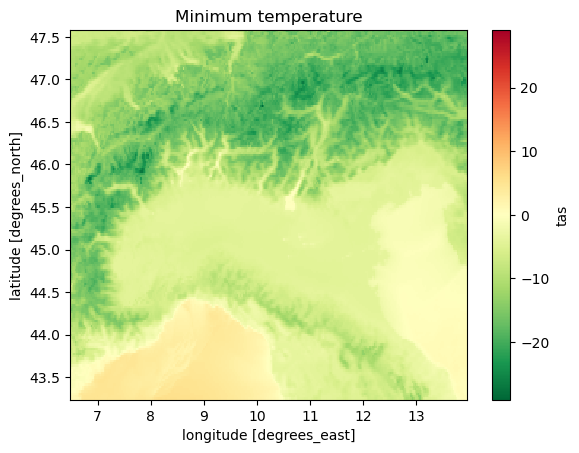

In [ ]:
(tas_eth.min(dim="time").tas-273.15).plot(cmap="RdYlGn_r")
plt.title("Minimum temperature")

# PANEL MERIDA GRIPHO SPHERA ENSEMBLE

In [4]:
#Load MERIDA
merida=xr.open_mfdataset("/mnt/data/lcesarini/MERIDA/prec/MERIDA_HRES_PREC_200*.nc").load()
merida=merida.isel(XTIME=merida['XTIME.season'].isin("JJA"))
merida

<xarray.Dataset>
Dimensions:  (XTIME: 22080, lon: 329, lat: 323)
Coordinates:
  * XTIME    (XTIME) datetime64[ns] 2000-06-01 ... 2009-08-31T23:00:00
  * lon      (lon) float32 5.84 5.88 5.92 5.96 6.0 ... 18.84 18.88 18.92 18.96
  * lat      (lat) float32 48.25 48.21 48.17 48.13 ... 35.49 35.45 35.41 35.37
Data variables:
    tp       (XTIME, lat, lon) float32 nan nan nan nan nan ... nan nan nan nan
Attributes: (12/13)
    CDI:            Climate Data Interface version 1.9.3 (http://mpimet.mpg.d...
    history:        Mon Jul 04 11:42:13 2022: cdo setrtomiss,-9.0000e+33,-9.0...
    source:         WRF3.9
    institution:    RSE S.p.A. - Ricerca sul Sistema Energetico
    Conventions:    CF-1.6
    title:          MERIDA HRES - MEteorological Reanalysis Italian DAtaset H...
    ...             ...
    driving_model:  ERA5
    resolution:     0.04 deg - regular lat-lon
    frequency:      1 hr
    references:     Lacavalla,M., Bonanno,R., Sperati,S.,2020. Dataset MERIDA...
    founding:       This work has been financed by the Research Fund for the ...
    CDO:            Climate Data Operators version 1.9.3 (http://mpimet.mpg.d...

In [5]:
merida_q=merida.quantile(dim='XTIME',q=0.999)
merida_q

<xarray.Dataset>
Dimensions:   (lon: 329, lat: 323)
Coordinates:
  * lon       (lon) float32 5.84 5.88 5.92 5.96 6.0 ... 18.84 18.88 18.92 18.96
  * lat       (lat) float32 48.25 48.21 48.17 48.13 ... 35.49 35.45 35.41 35.37
    quantile  float64 0.999
Data variables:
    tp        (lat, lon) float32 nan nan nan nan nan nan ... nan nan nan nan nan

In [8]:
lvl_q=[
    2,
    5,
    8 ,
    11, 
    14, 
    17, 
    20, 
    23, 
    26
 ]

In [9]:
def plot_merida():
    ax=plt.axes(projection=ccrs.PlateCarree())
    merida_q.tp.plot(cmap=cmap_q,levels=lvl_q,ax=ax)
    # ax.set_extent([6.5,13.95,43.25,47.57])
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)
    ax.set_title("MERIDA")

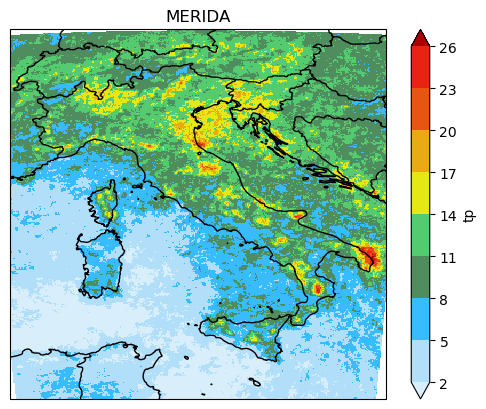

In [10]:
plot_merida()

In [8]:
#LOAD GRIPHO
gripho=xr.open_mfdataset("/mnt/data/lcesarini/gripho_3km.nc").load()

In [9]:
gripho=gripho.isel(time=gripho['time.season'].isin("JJA"))
gripho=gripho.isel(time=gripho['time.year'].isin(np.arange(2000,2010)))
gripho

<xarray.Dataset>
Dimensions:  (time: 19872, y: 402, x: 353)
Coordinates:
  * time     (time) datetime64[ns] 2001-06-01T00:22:30 ... 2009-08-31T23:22:30
    lon      (y, x) float32 6.998 7.032 7.065 7.098 ... 20.23 20.27 20.31 20.35
    lat      (y, x) float32 36.56 36.57 36.57 36.57 ... 47.0 47.0 47.0 46.99
  * x        (x) float64 4.05e+06 4.053e+06 4.056e+06 ... 5.103e+06 5.106e+06
  * y        (y) float64 1.505e+06 1.508e+06 1.511e+06 ... 2.705e+06 2.708e+06
Data variables:
    crs      int32 1
    pr       (time, y, x) float32 nan nan nan nan nan ... nan nan nan nan nan
Attributes: (12/22)
    CDI:                            Climate Data Interface version 1.9.8 (htt...
    Conventions:                    CF-1.7
    history:                        Fri Mar 19 12:49:39 2021: cdo -L -z zip -...
    source:                         Precipitation data from in-situ stations ...
    institution:                    ICTP
    crs:                            +proj=laea +lat_0=52 +lon_0=10 +x_0=43210...
    ...                             ...
    title:                          GRIPHO - GRidded Italian Precipitation Ho...
    contact:                        afantini@ictp.it
    references:                     Fantini et al. (2019, in publication)
    version:                        v1.0
    years_available:                2001-2016
    CDO:                            Climate Data Operators version 1.9.8 (htt...

In [10]:
gripho_q=gripho.quantile(dim='time',q=0.999)


In [11]:
def plot_gripho():
    ax=plt.axes(projection=ccrs.PlateCarree())
    gripho_q.pr.plot(cmap=cmap_q,levels=lvl_q,ax=ax,
                    transform=ccrs.LambertAzimuthalEqualArea(central_latitude=52.0,
                                                            central_longitude=10.0,
                                                            false_easting=4321000,
                                                            false_northing=3210000))
    ax.set_extent([6.5,13.95,43.25,47.57])
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS)

In [13]:
# fig, axs = plt.subplots(2, 2, figsize=(16, 12),subplot_kw={"projection":ccrs.PlateCarree()})

# merida_q.tp.plot(cmap=cmap_q,levels=lvl_q,ax=axs[0])
# axs[0].set_extent([6.5,13.95,43.25,47.57])
# axs[0].coastlines()
# axs[0].add_feature(cfeature.BORDERS)
# axs[0].set_title("MERIDA")


# gripho_q.pr.plot(cmap=cmap_q,levels=lvl_q,ax=axs[1],
#                 transform=ccrs.LambertAzimuthalEqualArea(central_latitude=52.0,
#                                                         central_longitude=10.0,
#                                                         false_easting=4321000,
#                                                         false_northing=3210000))
# axs[1].set_extent([6.5,13.95,43.25,47.57])
# axs[1].coastlines()
# axs[1].add_feature(cfeature.BORDERS)
# axs[1].set_title("GRIPHO")

# ax=plt.axes(projection=ccrs.PlateCarree())
# sphera_q.pr.plot(cmap=cmap_q,levels=lvl_q,ax=ax)
# ax.set_extent([6.5,13.95,43.25,47.57])
# ax.coastlines()
# ax.add_feature(cfeature.BORDERS)

# #load_ensemble
# ens=xr.load_dataset("/home/lcesarini/2022_resilience/output/JJA/ENSEMBLE_q.nc")

# ax=plt.axes(projection=ccrs.PlateCarree())
# ens.pr.plot(cmap=cmap_q,levels=lvl_q,ax=ax)
# ax.set_extent([6.5,13.95,43.25,47.57])
# ax.coastlines()
# ax.add_feature(cfeature.BORDERS)

In [14]:
#load SPHERA
sphera_cal=[xr.open_mfdataset(f"/mnt/data/RESTRICTED/CARIPARO/DATA_FPS/reanalysis/SPHERA/pr/*{year}*") for year in np.arange(2000,2010)]
sphera_cal=xr.concat(sphera_cal,dim='time')
sphera=sphera_cal.isel(time=sphera_cal['time.season'].isin("JJA"))
sphera

<xarray.Dataset>
Dimensions:    (time: 22079, latitude: 158, longitude: 272)
Coordinates:
  * time       (time) datetime64[ns] 2000-06-01 ... 2009-08-31T23:00:00
    surface    float64 0.0
  * latitude   (latitude) float64 43.25 43.28 43.3 43.33 ... 47.51 47.54 47.57
  * longitude  (longitude) float64 6.5 6.527 6.555 6.582 ... 13.9 13.92 13.95
Data variables:
    pr         (time, latitude, longitude) float64 dask.array<chunksize=(1, 158, 272), meta=np.ndarray>
Attributes:
    GRIB_edition:            2
    GRIB_centre:             edzw
    GRIB_centreDescription:  Offenbach 
    GRIB_subCentre:          255
    Conventions:             CF-1.7
    institution:             Offenbach 
    history:                 2023-03-08T12:57 GRIB to CDM+CF via cfgrib-0.9.1...

In [15]:
sphera_q=sphera.load().quantile(dim='time',q=0.999)

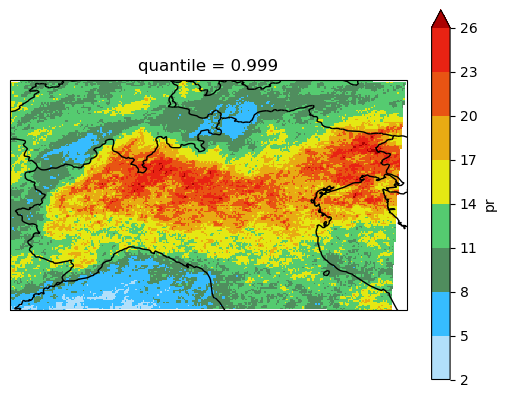

In [16]:
ax=plt.axes(projection=ccrs.PlateCarree())
sphera_q.pr.plot(cmap=cmap_q,levels=lvl_q,ax=ax)
ax.set_extent([6.5,13.95,43.25,47.57])
ax.coastlines()
ax.add_feature(cfeature.BORDERS)

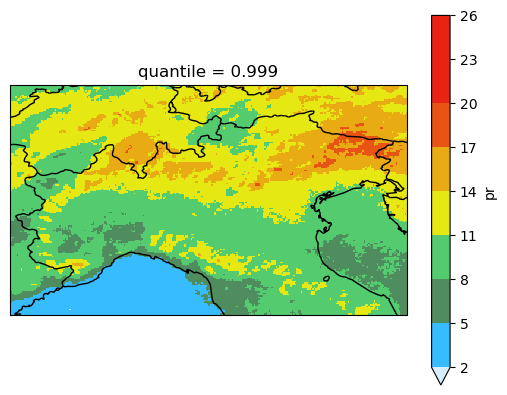

In [17]:
#load_ensemble
ens=xr.load_dataset("/home/lcesarini/2022_resilience/output/JJA/ENSEMBLE_q.nc")

ax=plt.axes(projection=ccrs.PlateCarree())
ens.pr.plot(cmap=cmap_q,levels=lvl_q,ax=ax)
ax.set_extent([6.5,13.95,43.25,47.57])
ax.coastlines()
ax.add_feature(cfeature.BORDERS)

In [27]:
lvl_q=[
    5,
    8,
    11, 
    14, 
    17, 
    20, 
    23, 
    26
 ]

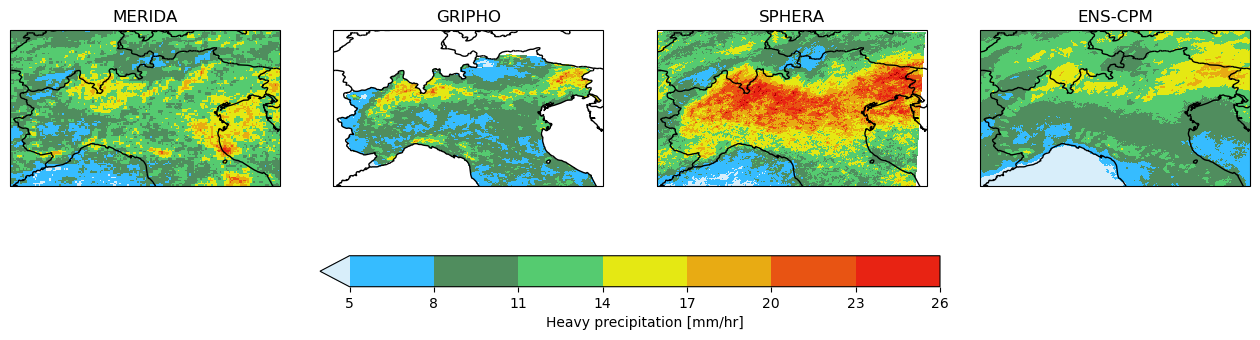

In [28]:
fig, axs = plt.subplots(1, 4, figsize=(16, 6),subplot_kw={"projection":ccrs.PlateCarree()})

axs=axs.flatten()
merida_q.tp.plot(cmap=cmap_q,levels=lvl_q,ax=axs[0],add_colorbar=False)
axs[0].set_extent([6.5,13.95,43.25,47.57])
axs[0].coastlines()
axs[0].add_feature(cfeature.BORDERS)
axs[0].set_title("MERIDA")


gripho_q.pr.plot(cmap=cmap_q,levels=lvl_q,ax=axs[1],add_colorbar=False,
                transform=ccrs.LambertAzimuthalEqualArea(central_latitude=52.0,
                                                        central_longitude=10.0,
                                                        false_easting=4321000,
                                                        false_northing=3210000))
axs[1].set_extent([6.5,13.95,43.25,47.57])
axs[1].coastlines()
axs[1].add_feature(cfeature.BORDERS)
axs[1].set_title("GRIPHO")

sphera_q.pr.plot(cmap=cmap_q,levels=lvl_q,ax=axs[2],add_colorbar=False)
axs[2].set_extent([6.5,13.95,43.25,47.57])
axs[2].coastlines()
axs[2].add_feature(cfeature.BORDERS)
axs[2].set_title("SPHERA")

#load_ensemble
ens=xr.load_dataset("/home/lcesarini/2022_resilience/output/JJA/ENSEMBLE_q.nc")

im=ens.pr.plot(cmap=cmap_q,levels=lvl_q,ax=axs[3],add_colorbar=False)
axs[3].set_extent([6.5,13.95,43.25,47.57])
axs[3].coastlines()
axs[3].add_feature(cfeature.BORDERS)
axs[3].set_title("ENS-CPM")

# cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
cbar = plt.colorbar(im, ax=axs[:],orientation='horizontal',label='Heavy precipitation [mm/hr]',shrink=0.5)


In [100]:
crop_to_extent(gripho_q)

<xarray.Dataset>
Dimensions:   (y: 91, x: 73)
Coordinates:
    lon       (y, x) float32 10.37 10.4 10.44 10.48 ... 13.11 13.15 13.19 13.23
    lat       (y, x) float32 44.7 44.7 44.7 44.7 ... 47.09 47.09 47.09 47.09
  * x         (x) float64 4.35e+06 4.353e+06 4.356e+06 ... 4.563e+06 4.566e+06
  * y         (y) float64 2.399e+06 2.402e+06 2.405e+06 ... 2.666e+06 2.669e+06
    quantile  float64 0.999
Data variables:
    crs       (y, x) float64 nan 1.0 1.0 1.0 1.0 1.0 ... 1.0 1.0 nan nan nan nan
    pr        (y, x) float32 nan 9.524 8.207 7.944 7.945 ... nan nan nan nan nan

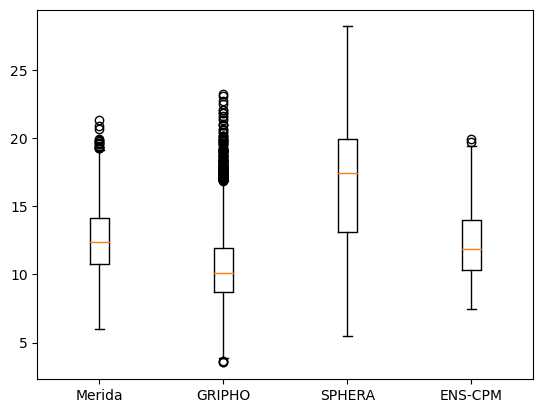

In [101]:
ax=plt.axes()
ax.boxplot(crop_to_extent(merida_q).tp.values.ravel()[np.isfinite(crop_to_extent(merida_q).tp.values.ravel())],positions=[0]);
ax.boxplot(crop_to_extent(gripho_q).pr.values.ravel()[np.isfinite(crop_to_extent(gripho_q).pr.values.ravel())],positions=[1]);
ax.boxplot(crop_to_extent(sphera_q).pr.values.ravel()[np.isfinite(crop_to_extent(sphera_q).pr.values.ravel())],positions=[2]);
ax.boxplot(crop_to_extent(ens).pr.values.ravel()[np.isfinite(crop_to_extent(ens).pr.values.ravel())],positions=[3]);

ax.set_xticklabels(["Merida","GRIPHO","SPHERA","ENS-CPM"]);
# gripho_q.pr.plot(cmap=cmap_q,levels=lvl_q,ax=axs[1],add_colorbar=False,axs[1].set_extent([6.5,13.95,43.25,47.57])
# axs[1].coastlines()
# axs[1].add_feature(cfeature.BORDERS)
# axs[1].set_title("GRIPHO")

# sphera_q.pr.plot(cmap=cmap_q,levels=lvl_q,ax=axs[2],add_colorbar=False)
# axs[2].set_extent([6.5,13.95,43.25,47.57])
# axs[2].coastlines()
# axs[2].add_feature(cfeature.BORDERS)
# axs[2].set_title("SPHERA")

# #load_ensemble
# ens=xr.load_dataset("/home/lcesarini/2022_resilience/output/JJA/ENSEMBLE_q.nc")

# im=ens.pr.plot(cmap=cmap_q,levels=lvl_q,ax=axs[3],add_colorbar=False)
# axs[3].set_extent([6.5,13.95,43.25,47.57])
# axs[3].coastlines()
# axs[3].add_feature(cfeature.BORDERS)
# axs[3].set_title("ENS-CPM")

# # cax = fig.add_axes([0.92, 0.1, 0.02, 0.8])
# cbar = plt.colorbar(im, ax=axs[2:],orientation='horizontal',label='Heavy precipitation [mm/hr]')

In [14]:
degree_to_meters(merida.lon.values[1].item()-merida.lon.values[0].item())

4445.555760383606

In [20]:
q=merida.tp.quantile(q=0.99,dim='XTIME')

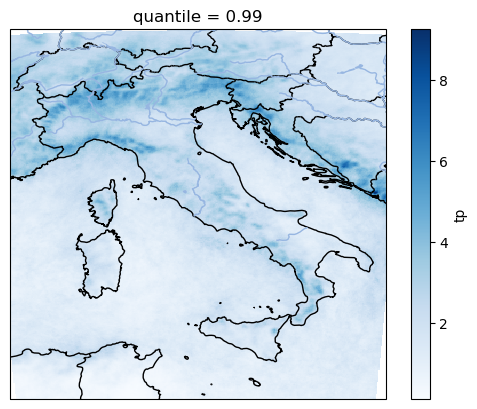

In [21]:
ax=plt.axes(projection=ccrs.PlateCarree())
q.plot(cmap="Blues",ax=ax)
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAKES)
ax.add_feature(cfeature.RIVERS)

In [70]:

sphera_cal=[xr.open_mfdataset(f"/mnt/data/RESTRICTED/CARIPARO/DATA_FPS/reanalysis/SPHERA/pr/*{year}*") for year in np.arange(2000,2005)]
sphera_adj=[xr.open_mfdataset(f"/mnt/data/RESTRICTED/CARIPARO/DATA_FPS/reanalysis/SPHERA/pr/*{year}*") for year in np.arange(2005,2010)]

In [79]:
sta_cal=xr.open_mfdataset([f"/mnt/data/RESTRICTED/CARIPARO/DATA_FPS/stations/pr/pr_st_{year}.nc" for year in np.arange(2000,2005)]).load()
sta_val=xr.open_mfdataset([f"/mnt/data/RESTRICTED/CARIPARO/DATA_FPS/stations/pr/pr_st_{year}.nc" for year in np.arange(2005,2010)]).load()


In [71]:
sphera_cal=xr.concat(sphera_cal,dim='time')

In [72]:
sphera_adj=xr.concat(sphera_adj,dim='time')


In [73]:
sphera_cal=sphera_cal.pr.sel(longitude=11.91734219,latitude=45.06494713,time=sphera_cal['time.season'].isin("DJF"),method='nearest')
sphera_adj=sphera_adj.pr.sel(longitude=11.91734219,latitude=45.06494713,time=sphera_adj['time.season'].isin("DJF"),method='nearest')

In [80]:
obs_val=sta_val.isel(lon=55,lat=13).sel(time=sta_val['time.season'].isin("DJF")).pr
obs_cal=sta_cal.isel(lon=55,lat=13).sel(time=sta_cal['time.season'].isin("DJF")).pr

In [81]:
sort_wh_cal=np.sort(obs_cal[obs_cal > 0.2])
sort_wh_val=np.sort(obs_val[obs_val > 0.2])

In [76]:
sorted_sphera_cal=np.sort(sphera_cal[sphera_cal > 0.1])
sorted_sphera_cal

array([0.10009766, 0.10058594, 0.10070801, 0.10107422, 0.10302734,
       0.10302734, 0.10449219, 0.10449219, 0.10546875, 0.10644531,
       0.10681152, 0.10693359, 0.10839844, 0.10839844, 0.10839844,
       0.109375  , 0.109375  , 0.109375  , 0.10986328, 0.11264038,
       0.11328125, 0.11328125, 0.11523438, 0.11547852, 0.11608887,
       0.11669922, 0.1171875 , 0.1171875 , 0.11816406, 0.1184082 ,
       0.12036133, 0.12109375, 0.12133789, 0.12207031, 0.12255859,
       0.12304688, 0.12347412, 0.12353516, 0.125     , 0.12548828,
       0.12695312, 0.12890625, 0.12939453, 0.12991714, 0.13037109,
       0.13061523, 0.13238525, 0.1328125 , 0.1328125 , 0.13330078,
       0.13330078, 0.13378906, 0.13378906, 0.13464355, 0.13476562,
       0.13598633, 0.13671875, 0.13757324, 0.13769531, 0.13842773,
       0.13867188, 0.13964844, 0.14038086, 0.140625  , 0.140625  ,
       0.14221191, 0.14355469, 0.14453125, 0.14526367, 0.14672852,
       0.14746094, 0.15087891, 0.15234375, 0.15356445, 0.15527

In [77]:
sorted_sphera_adj=np.sort(sphera_adj[sphera_adj > 0.1])
sorted_sphera_adj

array([0.10003185, 0.10058594, 0.1015625 , 0.10205078, 0.10253906,
       0.10351562, 0.10351562, 0.10400391, 0.10400391, 0.10400391,
       0.10449219, 0.10546875, 0.10546875, 0.10571289, 0.10644531,
       0.10730028, 0.10742188, 0.10754395, 0.10839844, 0.10986328,
       0.11035156, 0.11088943, 0.11108398, 0.11117554, 0.11132812,
       0.11132812, 0.11132812, 0.11132812, 0.11230469, 0.11328125,
       0.11328125, 0.11328125, 0.11425781, 0.11425781, 0.11474609,
       0.11523438, 0.11555481, 0.11572266, 0.11621094, 0.11633301,
       0.11669922, 0.11767578, 0.12011719, 0.12109375, 0.12109375,
       0.12207031, 0.12255859, 0.12304688, 0.12304688, 0.12353516,
       0.1237793 , 0.12460899, 0.12475586, 0.125     , 0.125     ,
       0.12524414, 0.12573242, 0.12597656, 0.1262207 , 0.12695312,
       0.12695312, 0.12695312, 0.12701797, 0.12744141, 0.12792969,
       0.12792969, 0.12890625, 0.13085938, 0.13085938, 0.13085938,
       0.13232422, 0.13330078, 0.13476562, 0.13476562, 0.13476

(0.975, 1.0)

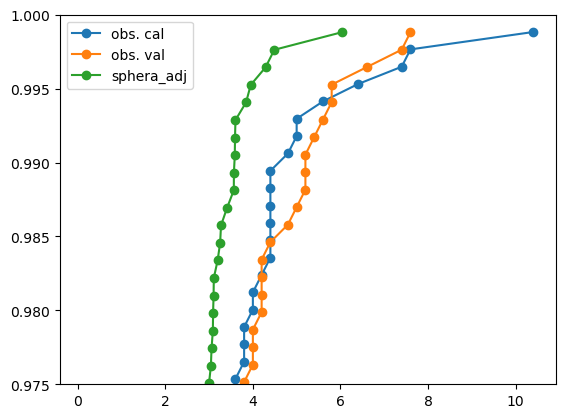

In [82]:
ax=plt.axes()
plt.plot(sort_wh_cal,np.arange(1,1+sort_wh_cal.shape[0]) / (1+sort_wh_cal.shape[0]),'-o',label='obs. cal')
plt.plot(sort_wh_val,np.arange(1,1+sort_wh_val.shape[0]) / (1+sort_wh_val.shape[0]),'-o',label='obs. val')
plt.plot(sorted_sphera_adj,np.arange(1,1+sorted_sphera_adj.shape[0]) / (1+sorted_sphera_adj.shape[0]),'-o',label='sphera_adj')
plt.legend()
ax.set_ylim([0.975,1])

In [14]:
np.sort(.pr.values[sta_val.isel(lon=55,lat=13).pr > 0.2])

IndexError: boolean index did not match indexed array along dimension 0; dimension is 10824 but corresponding boolean dimension is 43824

In [8]:
ds=xr.open_dataset("/home/lcesarini/2022_resilience/output/bootstrap/EQM/DJF/bias_heavy_prec_EQM_SPHERA_DJF_6.nc")
ds

<xarray.Dataset>
Dimensions:  (lon: 99, lat: 88)
Coordinates:
  * lon      (lon) float64 10.4 10.43 10.46 10.49 ... 13.02 13.04 13.07 13.1
  * lat      (lat) float64 44.71 44.73 44.76 44.79 ... 47.02 47.04 47.07 47.1
Data variables:
    pr       (lat, lon) float64 ...

Text(0.5, 1.0, 'CMCC')

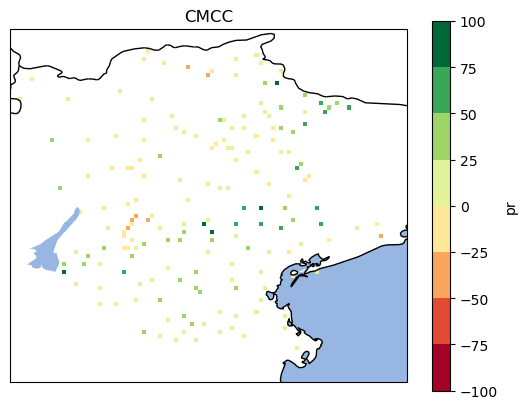

In [10]:
ax=plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN)
ds.pr.plot(cmap="RdYlGn",levels=10)
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAKES)
plt.title("CMCC")

Text(0.5, 1.0, 'CMCC')

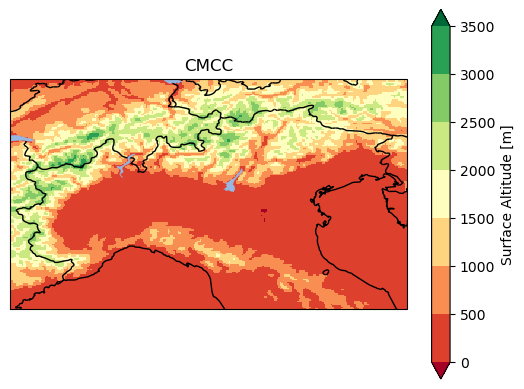

In [23]:
ax=plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN)
oro1=xr.open_dataset("/mnt/data/RESTRICTED/CARIPARO/DATA_FPS/ECMWF-ERAINT/CMCC/orog_ALP-3_ECMWF-ERAINT_evaluation_r0i0p0_CLMcom-CMCC-CCLM5-0-9_fpsconv-x2yn2-v1_fx.nc")
oro1.orog.plot(cmap="RdYlGn",levels=np.arange(0,4000,500))
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAKES)
plt.title("CMCC")

Text(0.5, 1.0, 'HCLIMcom')

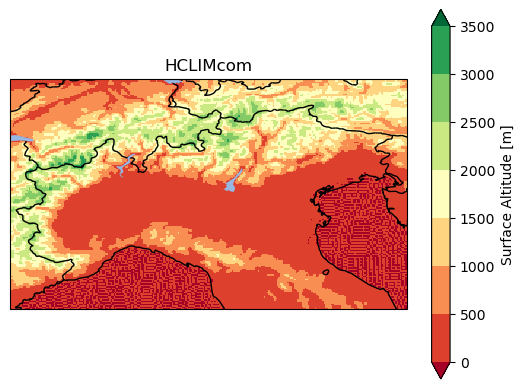

In [24]:
ax=plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN)
oro2=xr.open_dataset("/mnt/data/RESTRICTED/CARIPARO/DATA_FPS/ECMWF-ERAINT/HCLIMcom/orog_ALP-3_ECMWF-ERAINT_evaluation_r0i0p0_HCLIMcom-HCLIM38-AROME_fpsconv-x2yn2-v1_fx.nc")
oro2.orog.plot(cmap="RdYlGn",levels=np.arange(0,4000,500))
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAKES)
plt.title("HCLIMcom")

In [27]:
oro1.orog.sel(lon=12,lat=45,method="nearest").values-oro2.orog.sel(lon=12,lat=45,method="nearest").values

6.046922206878662

In [43]:
xr.open_dataset("/mnt/data/RESTRICTED/CARIPARO/DATA_FPS/ECMWF-ERAINT/KIT/sftlf_ALP-3_MPI-M-MPI-ESM-LR_historical_r0i0p0_CLMcom-KIT-CCLM5-0-15_fpsconv-x2yn2-v1_fx.nc")

<xarray.Dataset>
Dimensions:  (lon: 272, lat: 158)
Coordinates:
  * lon      (lon) float64 6.5 6.527 6.555 6.582 6.61 ... 13.87 13.9 13.92 13.95
  * lat      (lat) float64 43.25 43.28 43.3 43.33 ... 47.48 47.51 47.54 47.57
Data variables:
    sftlf    (lat, lon) float32 ...
Attributes: (12/33)
    CDI:                            Climate Data Interface version 1.9.8 (htt...
    history:                        Mon Sep 18 13:30:26 2023: cdo remapycon,n...
    source:                         Climate Limited-area Modelling Community ...
    institution:                    IMK-TRO/KIT, Karlsruhe, Germany in collab...
    Conventions:                    CF-1.4
    conventionsURL:                 http://www.cfconventions.org
    ...                             ...
    product:                        output
    frequency:                      fx
    tracking_id:                    49988aa4-0be2-11eb-bda3-98f2b312add8
    creation_date:                  2020-10-11 18:53:29
    NCO:                            netCDF Operators version 4.8.1 (Homepage ...
    CDO:                            Climate Data Operators version 1.9.8 (htt...

Text(0.5, 1.0, 'KIT SLTF')

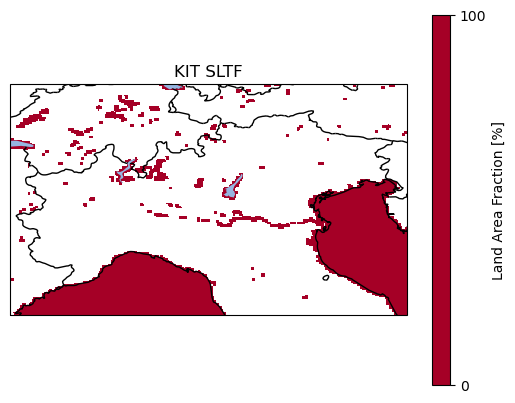

In [45]:
ax=plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN)
oro2=xr.open_dataset("/mnt/data/RESTRICTED/CARIPARO/DATA_FPS/ECMWF-ERAINT/KIT/sftlf_ALP-3_MPI-M-MPI-ESM-LR_historical_r0i0p0_CLMcom-KIT-CCLM5-0-15_fpsconv-x2yn2-v1_fx.nc")
oro2.sftlf.plot(cmap="RdYlGn",levels=2)
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAKES)
plt.title("KIT SLTF")

Text(0.5, 1.0, 'KIT')

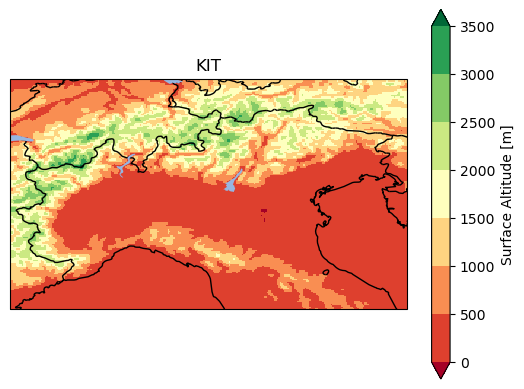

In [32]:
ax=plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN)
oro2=xr.open_dataset("/mnt/data/RESTRICTED/CARIPARO/DATA_FPS/ECMWF-ERAINT/KIT/orog_ALP-3_MPI-M-MPI-ESM-LR_historical_r0i0p0_CLMcom-KIT-CCLM5-0-15_fpsconv-x2yn2-v1_fx.nc")
oro2.orog.plot(cmap="RdYlGn",levels=np.arange(0,4000,500))
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAKES)
plt.title("KIT")


In [35]:
xr.open_dataset("/mnt/data/gfosser/DATA_FPS/sftlf_ALP-3_CNRM-CERFACS-CNRM-CM5_historical_r1i1p1_CNRM-AROME41t1_fx.nc" )

<xarray.Dataset>
Dimensions:   (y: 487, x: 587, nv4: 4)
Coordinates:
    lat       (y, x) float64 ...
    lon       (y, x) float64 ...
Dimensions without coordinates: y, x, nv4
Data variables:
    lat_bnds  (y, x, nv4) float64 ...
    lon_bnds  (y, x, nv4) float64 ...
    sftlf     (y, x) float64 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.7.1 (http://mpimet.mpg.d...
    Conventions:  CF-1.6
    history:      Mon Jun 22 15:53:28 2020: ncks -x -v longitude,latitude sft...
    made_with:    epygram-1.3.7
    NCO:          netCDF Operators version 4.7.9 (Homepage = http://nco.sf.ne...
    CDO:          Climate Data Operators version 1.9.7.1 (http://mpimet.mpg.d...

Text(0.5, 1.0, 'KNMI')

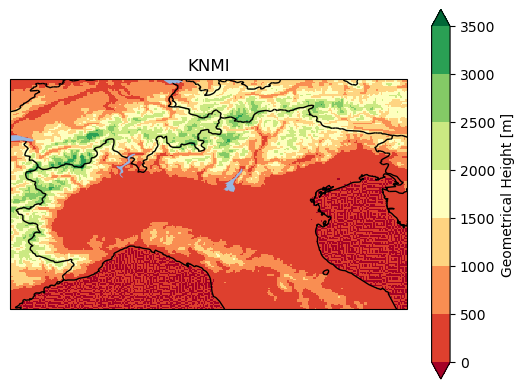

In [33]:
ax=plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN)
oro2=xr.open_dataset("/mnt/data/RESTRICTED/CARIPARO/DATA_FPS/ECMWF-ERAINT/KNMI/orog_ALP-3_ECMWF-ERAINT_evaluation_r1i1p1_KNMI-HCLIM38h1-AROME_fpsconv-x2yn2-v1_fx.nc")
oro2.orog.plot(cmap="RdYlGn",levels=np.arange(0,4000,500))
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAKES)
plt.title("KNMI")

In [38]:
xr.open_dataset("/mnt/data/RESTRICTED/CARIPARO/DATA_FPS/ECMWF-ERAINT/MOHC/orog_ALP-3_ECMWF-ERAINT_evaluation_r1i1p1_HadREM3-RA-UM10.1_fpsconv-x0n1-v1_fx.nc")

<xarray.Dataset>
Dimensions:           (lon: 272, lat: 158)
Coordinates:
  * lon               (lon) float64 6.5 6.527 6.555 6.582 ... 13.9 13.92 13.95
  * lat               (lat) float64 43.25 43.28 43.3 43.33 ... 47.51 47.54 47.57
Data variables:
    surface_altitude  (lat, lon) float32 ...
Attributes:
    CDI:          Climate Data Interface version 1.9.8 (https://mpimet.mpg.de...
    history:      Mon Sep 18 13:27:35 2023: cdo remapycon,newcommongrid.txt /...
    source:       Data from Met Office Unified Model
    Conventions:  CF-1.5
    um_version:   10.1
    CDO:          Climate Data Operators version 1.9.8 (https://mpimet.mpg.de...

Text(0.5, 1.0, 'MOHC')

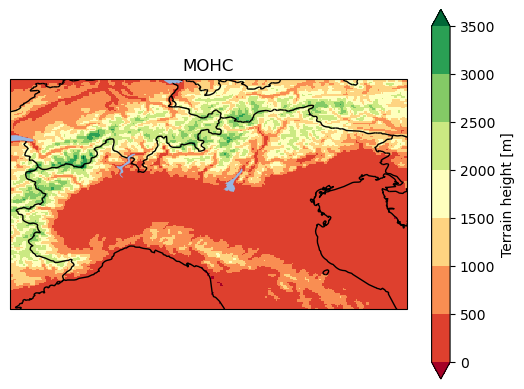

In [39]:
ax=plt.axes(projection=ccrs.PlateCarree())
ax.add_feature(cfeature.OCEAN)
oro2=xr.open_dataset("/mnt/data/RESTRICTED/CARIPARO/DATA_FPS/ECMWF-ERAINT/MOHC/orog_ALP-3_ECMWF-ERAINT_evaluation_r1i1p1_HadREM3-RA-UM10.1_fpsconv-x0n1-v1_fx.nc")
oro2.surface_altitude.plot(cmap="RdYlGn",levels=np.arange(0,4000,500))
ax.coastlines()
ax.add_feature(cfeature.BORDERS)
ax.add_feature(cfeature.LAKES)
plt.title("MOHC")

In [ ]:
ran=xr.open_dataset("/mnt/data/lcesarini/BIAS_CORRECTED/EQM/CNRM/pr/CNRM_CORR_STATIONS_JJA_Q1000_RANDOM_VALIDATION.nc")
seq=xr.open_dataset("/mnt/data/lcesarini/BIAS_CORRECTED/EQM/CNRM/pr/CNRM_CORR_STATIONS_JJA_Q1000_SEQUENTIAL_VALIDATION.nc")

In [ ]:
q99_ran=ran.pr.quantile(q=0.999,dim='time')
q99_seq=seq.pr.quantile(q=0.999,dim='time')

In [ ]:
q99_seq.plot()

In [ ]:
df1=pd.read_csv("csv/Ensemble_q_DJF_EQM_SEQUENTIAL.csv") 
df2=pd.read_csv("csv/Ensemble_q_DJF_EQM_RANDOM.csv")
print(np.nanmax(df1.q - df2.q))

# EVENT DEFINITION


In [ ]:
a_mdl=xr.open_mfdataset("/mnt/data/RESTRICTED/CARIPARO/DATA_FPS/ECMWF-ERAINT/CMCC/CPM/pr/*")

In [ ]:
a_mdl_cl=a_mdl.isel(lon=12,lat=22)
a_mdl_cl

In [ ]:
a_mdl_cl.pr

In [ ]:
df=nc_to_csv(cpm_sph.pr.quantile(dim='time',q=0.999),name="ff",M="pr",csv=False)
gdf=gpd.GeoDataFrame(df.loc[np.isfinite(df.pr)],
                     geometry=gpd.points_from_xy(df.loc[np.isfinite(df.pr)]['lon'],
                                                 df.loc[np.isfinite(df.pr)]['lat']),crs="EPSG:4326")

In [ ]:
ADJUST='VALIDATION'
list_ref_train=[glob(f"{PATH_COMMON_DATA}/../reanalysis/SPHERA/pr/*{year}*") for year in np.arange(2000,2005)]

if ADJUST=="TRAIN":
    list_ref_adjust=list_ref_train
elif ADJUST=="VALIDATION":
    list_ref_adjust=[glob(f"{PATH_COMMON_DATA}/../reanalysis/SPHERA/pr/*{year}*") for year in np.arange(2005,2010)]


In [ ]:
# ref_train=xr.open_mfdataset([item for list in list_ref_train for item in list]).load()
ref_adjust=xr.open_mfdataset([item for list in list_ref_adjust for item in list]).load()
sta_adjust=xr.open_mfdataset([f"{PATH_COMMON_DATA}/../stations/pr/pr_st_{year}.nc" for year in np.arange(2005,2010)])
# sta_train=xr.open_mfdataset([f"{PATH_COMMON_DATA}/../stations/pr/pr_st_{year}.nc" for year in np.arange(2000,2005)])
max_sta=np.nanmax(sta_adjust.pr.values[:,:,:],axis=2)
max_sta

In [ ]:
#MEAN INTENSITY WET HOURS
nc_to_csv(xr.where(get_season(sta_adjust,"JJA") > 0.1, get_season(sta_adjust,"JJA"),np.nan).mean(dim='time'),
                 name=f"Stations_i_JJA",M="i",csv=True)


In [ ]:
get_season(sta_adjust,"JJA")

In [ ]:
#HEAVY PRECIPITATION
nc_to_csv(get_season(sta_adjust,"JJA").load().quantile(dim='time',q=0.999),
                 name=f"Stations_q_JJA_valid",M="q",csv=True)



In [ ]:
list_mdl=["MOHC","ETH","CNRM","KNMI","HCLIMcom","KIT","CMCC","ICTP"]
ds_mod = []

for mdl in tqdm(list_mdl):
    """
    Approximate time for the loop:
    ~ 6 minutes
    """
    list_mod_adjust=[]

    if mdl == "ETH":
        from resilience.utils.fix_year_eth import fix_eth
        eth=fix_eth()
        
        if ADJUST=="TRAIN":
            mod_train=eth.sel(time=slice("2000-01-01","2004-12-31")).load()
            mod_adjust=mod_train
        elif ADJUST=="VALIDATION":
            mod_adjust=eth.sel(time=slice("2005-01-01","2009-12-31")).load()

        ds_mod.append(get_triveneto(mod_adjust.pr,sta_adjust))
    elif mdl == "ICTP":
        if ADJUST=="TRAIN":
            for year in np.arange(2000,2004):
                list_mod_adjust=list_mod_adjust+glob(f"{PATH_COMMON_DATA}/{mdl}/CPM/pr/*{year}*")
        elif ADJUST=='VALIDATION':
            for year in np.arange(2006,2010):
                list_mod_adjust=list_mod_adjust+glob(f"{PATH_COMMON_DATA}/{mdl}/CPM/pr/*{year}*")
        
        ds_mod.append(get_triveneto(xr.open_mfdataset(list_mod_adjust).pr,sta_adjust).load())
    else:
        if ADJUST=="TRAIN":
            for year in np.arange(2000,2005):
                list_mod_adjust=list_mod_adjust+glob(f"{PATH_COMMON_DATA}/{mdl}/CPM/pr/*{year}*")
        elif ADJUST=='VALIDATION':
            for year in np.arange(2005,2010):
                list_mod_adjust=list_mod_adjust+glob(f"{PATH_COMMON_DATA}/{mdl}/CPM/pr/*{year}*")

        ds_mod.append(get_triveneto(xr.open_mfdataset(list_mod_adjust).pr,sta_adjust).load())

In [ ]:
ds_mod_dict={mdl:ds_mod[i] for i,mdl in enumerate(list_mdl)}

In [ ]:
ds_mod_dict['ETH']['time']=ds_mod_dict['MOHC'].time

In [ ]:
dict_q999=[get_season(ds_mod_dict[mdl],"JJA") for mdl in list_mdl]
dict_q999_ens=xr.concat(dict_q999,list_mdl).rename({'concat_dim':'model'})

In [ ]:
ens=dict_q999_ens
del dict_q999_ens
ens

# VHR 

In [ ]:
list_mod_adjust = []
for year in np.arange(2005,2010):
    list_mod_adjust=list_mod_adjust+glob(f"/mnt/data/RESTRICTED/CARIPARO/DATA_FPS/reanalysis/CMCC/pr/*{year}*")


In [ ]:
vhr_tri=get_triveneto(xr.open_mfdataset(list_mod_adjust).pr,sta_adjust).load()

In [ ]:
#Intenisty
nc_to_csv(xr.where(get_season(vhr_tri,"JJA") > 0.2, get_season(vhr_tri,"JJA"),np.nan).mean(dim='time'),
            name=f"VHR_i_JJA",M="i",csv=True)

In [ ]:
#Quantiles
nc_to_csv(get_season(vhr_tri,"JJA").quantile(dim='time',q=0.999),
            name=f"VHR_q_JJA_valid",M="q",csv=True)
            

# SPHERA

In [ ]:
ref_adjust=ref_adjust.rename({"longitude":"lon","latitude":"lat"})

In [ ]:
ref_adjust['lon']=mask.lon
ref_adjust['lat']=mask.lat

In [ ]:
ref_adjust_tri=get_triveneto(ref_adjust.pr,sta_adjust)
ref_adjust_tri

In [ ]:
df_ori=nc_to_csv(xr.where(get_season(ref_adjust_tri,"JJA") > 0.2, get_season(ref_adjust_tri,"JJA"),np.nan).mean(dim='time'),
                 name=f"SPHERA_i_JJA",M="i",csv=True)



In [ ]:
#Quantiles
nc_to_csv(get_season(ref_adjust_tri,"JJA").quantile(dim='time',q=0.999),
            name=f"SPHERA_q_JJA_valid",M="q",csv=True)

In [ ]:

gdf_ori=gpd.GeoDataFrame(df_ori.loc[np.isfinite(df_ori.pr)],
                     geometry=gpd.points_from_xy(df_ori.loc[np.isfinite(df_ori.pr)]['lon'],
                                                 df_ori.loc[np.isfinite(df_ori.pr)]['lat']),crs="EPSG:4326")

In [ ]:

fig,axs=plt.subplots(1,2,
                    figsize=(9,6),constrained_layout=True, squeeze=True,
                    subplot_kw={"projection":ccrs.PlateCarree()})

gdf.plot(column='pr', markersize=30,scheme="User_Defined", 
         legend=True, classification_kwds=dict(bins=[4,7,12,15,19,24,28,32]),
         ax=axs[0],cmap=cmap_q)
gdf_ori.plot(column='pr', markersize=30,scheme="User_Defined",
         legend=True, classification_kwds=dict(bins=[4,7,12,15,19,24,28,32]),
         ax=axs[1],cmap=cmap_q)
[axs[i].coastlines() for i in range(axs.shape[0])]
[axs[i].add_feature(cfeature.BORDERS) for i in range(axs.shape[0])]
[axs[i].add_feature(cfeature.OCEAN) for i in range(axs.shape[0])]
[axs[i].add_feature(cfeature.LAND) for i in range(axs.shape[0])]
[axs[i].add_feature(cfeature.LAKES) for i in range(axs.shape[0])]
[shp_triveneto.boundary.plot(ax=axs[i],edgecolor='red',transform=proj,linewidth=0.85) for i in range(axs.shape[0])]

# fig.colorbar(ax=axs,#ax=ax[i] if (nrow > 1) or (ncol > 1) else ax, 
#                   extend='both', 
#                   orientation='vertical',
#                   shrink=0.85)
# cbar.ax.tick_params(labelsize=30)
# cbar.ax.set_ylabel("pr",fontsize=10,rotation=0,loc='bottom')


In [ ]:
import sys
from time import sleep

for i in range(21):
    sys.stdout.write('\r')
    # the exact output you're looking for:
    sys.stdout.write("[%-20s] %d%%" % ('='*i, 5*i))
    sys.stdout.flush()
    sleep(0.25)

In [ ]:
import xarray as xr
x=xr.open_dataset("/mnt/data/lcesarini/gripho_3km.nc",chunks={'time':100})

In [ ]:
gripho_jja=x.isel(time=x['time.season'].isin(["JJA"]))

In [ ]:
gripho_jja_valid=gripho_jja.isel(time=gripho_jja['time.year'].isin(np.arange(2005,2010)))

In [ ]:
gripho_jja_valid

In [ ]:
rot=ccrs.LambertAzimuthalEqualArea(central_latitude=52,central_longitude=10,
                                    false_easting=4321000,false_northing=3210000)
# sta_val.where(np.isfinite(sta_val.pr))

x,y=np.where(np.isfinite(sta_adjust.pr.max(dim='time')))

X,Y=[],[]

for i in range(x.shape[0]):
    X.append(sta_adjust.isel(lon=y[i],lat=x[i]).lon.item())
    Y.append(sta_adjust.isel(lon=y[i],lat=x[i]).lat.item())

rlon=[rot.transform_point(x_,y_,ccrs.CRS("WGS84"))[0] for x_,y_ in zip(X,Y)]
rlat=[rot.transform_point(x_,y_,ccrs.CRS("WGS84"))[1] for x_,y_ in zip(X,Y)]


In [ ]:
x1=[gripho_jja_valid.sel(x=rx,y=ry,method='nearest').x.item() for rx,ry in zip(rlon,rlat)]
y1=[gripho_jja_valid.sel(x=rx,y=ry,method='nearest').y.item() for rx,ry in zip(rlon,rlat)]

In [ ]:
gripho_jja_valid=gripho_jja_valid.load()

In [ ]:
xr.where(gripho_jja_valid.sel(x=x1[1],y=y1[1]).pr > 0.2,gripho_jja_valid.sel(x=x1[1],y=y1[1]).pr,np.nan).mean().item()

In [ ]:
# MEAN INTENSITY WET HOURS
pr=[xr.where(gripho_jja_valid.sel(x=rx,y=ry).pr > 0.2,gripho_jja_valid.sel(x=rx,y=ry).pr,np.nan).mean().item() for rx,ry in zip(x1,y1)]
ln=[gripho_jja_valid.sel(x=rx,y=ry).lon.item() for rx,ry in zip(x1,y1)]
lt=[gripho_jja_valid.sel(x=rx,y=ry).lat.item() for rx,ry in zip(x1,y1)]



In [ ]:
# HEAVY PRECIPITATION
pr=[gripho_jja_valid.sel(x=rx,y=ry).pr.quantile(dim='time',q=0.999).item() for rx,ry in zip(x1,y1)]
ln=[gripho_jja_valid.sel(x=rx,y=ry).lon.item() for rx,ry in zip(x1,y1)]
lt=[gripho_jja_valid.sel(x=rx,y=ry).lat.item() for rx,ry in zip(x1,y1)]



In [ ]:
df=pd.DataFrame([ln,lt,pr]).transpose().rename({0:'lon',1:'lat',2:'q'},axis=1)
df.to_csv("/home/lcesarini/2022_resilience/csv/gripho_q_JJA_valid.csv")

#  PLOT HISTOGRAM or at least try

In [ ]:
sta_sli=sta_adjust.pr.values.reshape(-1)

In [ ]:
def get_df_ens(xr_ens,name_mdl):
    logs=xr_ens.sel(model=name_mdl).values.reshape(-1)
    logs=logs[logs > 0.1]
    logs=np.log(logs)
    # logs=logs[~np.isnan(logs)]
    logs
    df_ens=pd.DataFrame(logs).rename({0:name_mdl},axis=1)
    
    return df_ens


In [ ]:
ll_df_ens=[get_df_ens(ens,nm) for nm in ens.model.values]

In [ ]:
import random

number_of_colors = 8

color = ["#"+''.join([random.choice('0123456789ABCDEF') for j in range(6)])
             for i in range(number_of_colors)]
print(color)

In [ ]:
fig=plt.figure(figsize=(14,6))
ax=plt.axes()
[sns.kdeplot(ll_df_ens[i],ax=ax,label=nm,linewidth=3,alpha=0.5) for i,nm in enumerate(ens.model.values)]
[sns.distplot(ll_df_ens[i],ax=ax,label=nm,hist=False) for i,nm in enumerate(ens.model.values)]
# sns.kdeplot(ll_df_ens[1],log_scale=False,ax=ax,color="green")

ax.set_xticks(np.log([0.1,0.2,0.35,0.75,1,2.5,5,10,15,25,40,60,80,100]))
ax.set_xticklabels([0.1,0.2,0.35,0.75,1,2.5,5,10,15,25,40,60,80,100])
ax.set_xlim([np.log(0.3),np.log(110)])

ax.legend()

In [ ]:
#STATIONS
log_sta=np.log(sta_sli[sta_sli > 0.1])
log_sta=log_sta[np.isfinite(log_sta)]    
#GRIPHO
log_gri=np.log(gripho_jja_valid.pr.values.reshape(-1)[gripho_jja_valid.pr.values.reshape(-1) > 0.1])
log_gri=log_gri[np.isfinite(log_gri)]    
#SPHERA
log_sphe=np.log(ref_adjust_tri.values.reshape(-1)[ref_adjust_tri.values.reshape(-1) > 0.1])
log_sphe=log_sphe[np.isfinite(log_sphe)]    
#VHR
log_vhr=np.log(vhr_tri.values.reshape(-1)[vhr_tri.values.reshape(-1) > 0.1])
log_vhr=log_vhr[np.isfinite(log_vhr)]    
#Ensemble 

In [ ]:
fig=plt.figure(figsize=(14,6))
ax=plt.axes()
sns.distplot(log_sta,ax=ax,label="Stations",hist=False)
sns.distplot(log_vhr,ax=ax,label="VHR-CMCC",hist=False)
sns.distplot(log_sphe,ax=ax,label="SPHERA",hist=False)
sns.distplot(log_gri,ax=ax,label="GRIPHO",hist=False)
[sns.kdeplot(ll_df_ens[i],ax=ax,label=nm,linewidth=0.5,alpha=0.5) for i,nm in enumerate(ens.model.values)]

# sns.kdeplot(ll_df_ens[1],log_scale=False,ax=ax,color="green")

ax.set_xticks(np.log([0.1,0.2,0.35,0.75,1,2.5,5,10,15,25,40,60,80,100]))
ax.set_xticklabels([0.1,0.2,0.35,0.75,1,2.5,5,10,15,25,40,60,80,100])
ax.set_xlim([np.log(0.3),np.log(110)])
ax.set_ylim([0,0.6])

ax.legend()

In [ ]:
fig=plt.figure(figsize=(14,6))
ax=plt.axes()
sns.distplot(log_sta,ax=ax,label="Stations",hist=False)
sns.distplot(log_vhr,ax=ax,label="VHR-CMCC",hist=False)
sns.distplot(log_sphe,ax=ax,label="SPHERA",hist=False)
sns.distplot(log_gri,ax=ax,label="GRIPHO",hist=False)
[sns.kdeplot(ll_df_ens[i],ax=ax,label=nm,linewidth=0.5,alpha=0.5) for i,nm in enumerate(ens.model.values)]

# sns.kdeplot(ll_df_ens[1],log_scale=False,ax=ax,color="green")

ax.set_xticks(np.log([0.1,0.2,0.35,0.75,1,2.5,5,10,15,25,40,60,80,100]))
ax.set_xticklabels([0.1,0.2,0.35,0.75,1,2.5,5,10,15,25,40,60,80,100])
ax.set_xlim([np.log(30),np.log(110)])
ax.set_ylim([0,0.002])

ax.legend()

In [ ]:
# counts, bins = np.histogram(log_sta,bins=50)
fig=plt.figure(figsize=(16,12))
ax=plt.axes()
ax.hist(log_sta,bins=np.log([0.2,0.35,0.75,1,2.5,5,10,15,25,40,60,80,100]),density=True,color="white",edgecolor='red',alpha=0.2,label='Stations',linewidth=2)
ax.hist(log_gri,bins=np.log([0.2,0.35,0.75,1,2.5,5,10,15,25,40,60,80,100]),density=True,color="white",edgecolor='green',alpha=0.2,label='GRIPHO',linewidth=2)
ax.hist(log_sphe,bins=np.log([0.2,0.35,0.75,1,2.5,5,10,15,25,40,60,80,100]),density=True,color="white",edgecolor='magenta',alpha=0.2,label='SPHERA',linewidth=2)
ax.hist(log_vhr,bins=np.log([0.2,0.35,0.75,1,2.5,5,10,15,25,40,60,80,100]),density=True,color="white",edgecolor='blue',alpha=0.2,label='VHR-CMCC',linewidth=2)

ax.set_xticks(np.log([0.2,0.35,0.75,1,2.5,5,10,15,25,40,60,80,100]))
ax.set_xticklabels([0.2,0.35,0.75,1,2.5,5,10,15,25,40,60,80,100])
# ax.set_xlim([np.log(20),np.log(100)])
# ax.set_ylim([0])
plt.legend()

In [ ]:
df=pd.DataFrame([log_sta,log_gri,log_sphe,log_vhr]).transpose()

In [ ]:
df.rename({0:'Stations',1:'GRIPHO',2:'SPHERA',3:'VHR-CMCC'},axis=1)

In [ ]:
# counts, bins = np.histogram(log_sta,bins=50)
fig=plt.figure(figsize=(16,12))
ax=plt.axes()


In [ ]:
os.getcwd()

In [ ]:
meta_stations=pd.read_csv("meta_station_updated_col.csv")

rot=ccrs.LambertAzimuthalEqualArea(central_longitude=10, central_latitude=52,false_easting=4321000, false_northing=3210000) 

longitude,latitude=[],[]
for rlon,rlat in zip(meta_stations.lon,meta_stations.lat):
    lon,lat=rot.transform_point(rlon,rlat,ccrs.PlateCarree())
    longitude.append(lon)
    latitude.append(lat)

In [ ]:
df=pd.DataFrame([longitude,latitude]).transpose()
df.rename(columns={0:'lon',1:'lat'}).to_csv("coords_stations_gripho_csr.csv",index_label=False)

In [ ]:
PATH_OUTPUT=f"/home/lcesarini/2022_resilience/output/"
SEAS="JJA"
M='q'
sta=xr.load_dataset(f"{PATH_OUTPUT}/{SEAS}/STATIONS_{M}.nc").isel(quantile=0)
sta

In [ ]:
gripho_f=xr.load_dataset(f"{PATH_OUTPUT}{SEAS}/GRIPHO_ORIGINAL_f.nc")
gripho_i=xr.load_dataset(f"{PATH_OUTPUT}{SEAS}/GRIPHO_ORIGINAL_i.nc")
gripho_q=xr.load_dataset(f"{PATH_OUTPUT}{SEAS}/GRIPHO_ORIGINAL_q.nc").isel(quantile=0)
gripho_q

In [ ]:
val=[]
for lon,lat in zip(longitude,latitude):
    val.append(gripho_q.sel(x=lon,y=lat,method="nearest").pr.values.item())

In [ ]:
meta_stations.lon.values


In [ ]:
df=pd.DataFrame([meta_stations.lon.values,meta_stations.lat.values,val]).transpose()
df.rename(columns={0:'lon',1:'lat',2:'quantile'}).to_csv("heavy_prec_gripho.csv",index_label=False)

In [ ]:
xr.open_dataset("/mnt/data/lcesarini/tx14.nc").pr.isel(time=0).plot.pcolormesh()

In [ ]:
np.all(np.isnan(xr.open_dataset("/mnt/data/lcesarini/tx3.nc").pr.values))


In [ ]:
xr.open_dataset("/mnt/data/lcesarini/tx4.nc").pr.isel(time=0).plot.pcolormesh()

In [ ]:
ax=plt.axes(projection=ccrs.PlateCarree())

xr.open_dataset("/mnt/data/RESTRICTED/CARIPARO/DATA_FPS/ECMWF-ERAINT/KIT/CPM/pr/KIT_ECMWF-ERAINT_200101010030-200112312330.nc").\
    pr.isel(time=19).plot.pcolormesh(ax=ax)
shp_triveneto.boundary.plot(ec='red',ax=ax)

In [ ]:
ax=plt.axes(projection=ccrs.PlateCarree())
xr.open_dataset("/mnt/data/RESTRICTED/CARIPARO/DATA_FPS/Rcp85/KIT/CPM/pr/KIT_Rcp85_204101010030-204112312330.nc").\
    pr.isel(time=19).plot.pcolormesh(ax=ax)
shp_triveneto.boundary.plot(ec='red',ax=ax)

In [ ]:
x=xr.open_mfdataset("/mnt/data/lcesarini/tmp/remap*.nc").load()
x

In [ ]:
np.nanmax(x.pr.values)

In [ ]:
x99=x.pr.quantile(q=0.999,dim='time')

In [ ]:
shp_triveneto = gpd.read_file("/home/lcesarini/2022_resilience/data/gadm36_ITA.gpkg", layer="gadm36_ITA_1")
shp_triveneto = shp_triveneto[np.isin(shp_triveneto.NAME_1,["Veneto","Trentino-Alto Adige"])]


In [ ]:
shp_triveneto.bounds

In [ ]:
from resilience.utils.retrieve_data import clip_ds
from resilience.utils import *

lvl_f,lvl_i,lvl_q=get_levels()
cmap_f,cmap_i,cmap_q=get_palettes()
x_clip=clip_ds(x,10.38,13.2,44.75,47.01)

In [ ]:
x_clip_JJA=get_season(x_clip,season="JJA")
x99=x_clip_JJA.quantile(q=0.999,dim='time')
ax=plt.axes(projection=ccrs.PlateCarree())
shp_triveneto.boundary.plot(ax=ax,edgecolor='red')
x99.pr.plot.pcolormesh(ax=ax,
                       levels=lvl_q,cmap=cmap_q,
                    transform=ccrs.LambertAzimuthalEqualArea(central_latitude=52,
                                                             central_longitude=10,
                                                             false_easting=4321000,
                                                             false_northing=3210000))

In [ ]:
np.nanmax(x_JJA.pr)

In [ ]:
x_JJA=get_season(x,season="JJA")
x99=x_JJA.quantile(q=0.999,dim='time')
ax=plt.axes(projection=ccrs.PlateCarree())
shp_triveneto.boundary.plot(ax=ax,edgecolor='red')
x99.pr.plot.pcolormesh(ax=ax,
                       levels=lvl_q,cmap=cmap_q)

In [ ]:
%time
x=xr.open_mfdataset("/mnt/data/lcesarini/tmp/ECMWF-ERAINT/ETH/CPM/pr/*").load()


In [ ]:
np.repeat(np.arange(0,10/2),2)

In [ ]:
df=pd.read_csv("/home/lcesarini/2022_resilience/rea_sta_f.csv")
df['id']=np.repeat(np.arange(0,8712/2),2)
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lon, df.lat), crs="EPSG:4326"
)

gdf=gdf.iloc[0:20]





In [ ]:
ax=plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS, alpha=0.5)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
gdf.plot(ax=ax)


In [ ]:
gdf.groupby('id')['geometry']

In [ ]:
from shapely.geometry import LineString
gdf_lines = gdf.groupby('id')['geometry'].apply(lambda x: LineString(x.tolist()))
gdf_lines

In [ ]:
ax=plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(cfeature.LAKES, alpha=0.5)
ax.add_feature(cfeature.RIVERS, alpha=0.5)
ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.OCEAN)
gdf_lines.plot(ax=ax)

In [ ]:
ds_rem=xr.open_dataset(f"{PATH_COMMON_DATA}//MOHC/CPM/pr/MOHC_ECMWF-ERAINT_200104010030-200104302330.nc")
meta = pd.read_csv("stations/meta_stations_eval.csv")
ele=xr.open_dataset("/mnt/data/RESTRICTED/CARIPARO/datiDallan/CPM_ETH_Italy_2000-2009_pr_hour.nc")
eth__rg=xr.open_mfdataset(f"{PATH_COMMON_DATA}/ETH/CPM/pr/ETH_ECMWF-ERAINT_*.nc").load()


In [ ]:
STATIONS = ["VE_0088","VE_0100","TN_0147","AA_4740","VE_0239","VE_0011"]

idx_nat=pd.read_csv("indices_nat.txt",header=None,sep=" ")
gds=gpd.GeoDataFrame(meta,
                        geometry=gpd.points_from_xy(meta["lon"],
                                                    meta["lat"], 
                        crs="EPSG:4326"))


# Create csv of dates and precipitation.
### I made the join of the two csv in R

In [ ]:
#CHANGE THE PATHS
for idx,name_st in enumerate(STATIONS):
    gds_st=gds[gds.name==name_st]
    lon_grid=ds_rem.sel(lon=gds_st.lon.item(),lat=gds_st.lat.item(),method="nearest").lon.item()
    lat_grid=ds_rem.sel(lon=gds_st.lon.item(),lat=gds_st.lat.item(),method="nearest").lat.item()

    A=eth__rg.sel(lon=lon_grid,lat=lat_grid,method='nearest').pr
    # print(gds_st.lon.item(),gds_st.lat.item())
    # print(A.lon.values.item(),A.lat.values.item())
    pd.DataFrame(pd.to_datetime(A.time.values)).\
        to_csv(f"/home/lcesarini/2022_resilience/data/check_nathalia/dates_{name_st}_station.csv",
                index=0,
                header = ["date"]
                )
    pd.DataFrame(A.values).\
        to_csv(f"/home/lcesarini/2022_resilience/data/check_nathalia/pr_{name_st}_station.csv",
                index=0,
                header = ["pr"]
                )

# Differences between "old" stations
  
Old because are all the files I already gave to Nathalia.

There is a difference because I made a "mistake". The csv of the cells I gave you were obtained from the cell of teh remapped grid closest to the cell of the original grid, which was the closest to the station (i.e., based on the index chosen by Eleonora).

In [ ]:
st_old=pd.read_csv(f"/home/lcesarini/VE_0088.csv")
i_lon=idx_nat[idx_nat[0]==name_st][1].item()
i_lat=idx_nat[idx_nat[0]==name_st][2].item()

print({
"name":name_st,
"mean":eth__rg.isel(lon=i_lon,lat=i_lat).pr.values.mean() - st_old.pr.mean(),
"std" :eth__rg.isel(lon=i_lon,lat=i_lat).pr.values.std() - st_old.pr.std(),
"min" :eth__rg.isel(lon=i_lon,lat=i_lat).pr.values.min() - st_old.pr.min(),
"q25":(np.quantile(eth__rg.isel(lon=i_lon,lat=i_lat).pr.values,q=[0.25]) - np.quantile(st_old.pr,q=[0.25])).item(),
"q50":(np.quantile(eth__rg.isel(lon=i_lon,lat=i_lat).pr.values,q=[0.5]) - np.quantile(st_old.pr,q=[0.5])).item(),
"q75":(np.quantile(eth__rg.isel(lon=i_lon,lat=i_lat).pr.values,q=[0.75]) - np.quantile(st_old.pr,q=[0.75])).item(),
"max" :eth__rg.isel(lon=i_lon,lat=i_lat).pr.values.max() - st_old.pr.max(),
})


In [ ]:
metrics_eth=[]
for idx,name_st in enumerate(STATIONS):
    st_old=pd.read_csv(f"/home/lcesarini/{name_st}.csv")
    i_lon=idx_nat[idx_nat[0]==name_st][1].item()
    i_lat=idx_nat[idx_nat[0]==name_st][2].item()

    metrics_eth.append({
    "name":name_st,
    "mean":eth__rg.isel(lon=i_lon,lat=i_lat).pr.values.mean() - st_old.pr.mean(),
    "std" :eth__rg.isel(lon=i_lon,lat=i_lat).pr.values.std() - st_old.pr.std(),
    "min" :eth__rg.isel(lon=i_lon,lat=i_lat).pr.values.min() - st_old.pr.min(),
    "q25":(np.quantile(eth__rg.isel(lon=i_lon,lat=i_lat).pr.values,q=[0.25]) - np.quantile(st_old.pr,q=[0.25])).item(),
    "q50":(np.quantile(eth__rg.isel(lon=i_lon,lat=i_lat).pr.values,q=[0.5]) - np.quantile(st_old.pr,q=[0.5])).item(),
    "q75":(np.quantile(eth__rg.isel(lon=i_lon,lat=i_lat).pr.values,q=[0.75]) - np.quantile(st_old.pr,q=[0.75])).item(),
    "max" :eth__rg.isel(lon=i_lon,lat=i_lat).pr.values.max() - st_old.pr.max(),
    })

print(pd.DataFrame.from_dict(metrics_eth).transpose())


# Some details
Although the files that I gave you were slightly off with respect to the actual closest regrid cell to the stations, the results you showed in the email did not make a lot of sense to me.

The difference in the max is not that high, according to my computation. 
But more importantly, how is it possible that the difference in the minimum is so large given that the minimum in rainfall should be zero in any case?

Finally, the lower-mid quantiles taking into consideration also the dry hours are not very significant since there are a lot of zero.

# Differences between "correct" stations

Below is the same differences that you computed but with the correct selection of the closest regridded cell to the stations.

There are still some small differences (>= 1e-6) that are given by the fact that when saving numbers with several decimal numbers to a txt or csv, pandas or numpy drop some of the latest numbers for memory reason.


In [ ]:
#CHANGE ALWAYS PATH
metrics_st=[]
for idx,name_st in enumerate([STATIONS[0]]):
    st_new=pd.read_csv(f"/home/lcesarini/2022_resilience/data/check_nathalia/{name_st}_station.csv")
    i_lon=idx_nat[idx_nat[0]==name_st][1].item()
    i_lat=idx_nat[idx_nat[0]==name_st][2].item()

    metrics_st.append({
    "name":name_st,
    "mean":eth__rg.isel(lon=i_lon,lat=i_lat).pr.values.mean() - st_new.pr.mean(),
    "std" :eth__rg.isel(lon=i_lon,lat=i_lat).pr.values.std() - st_new.pr.std(),
    "min" :eth__rg.isel(lon=i_lon,lat=i_lat).pr.values.min() - st_new.pr.min(),
    "q25":(np.quantile(eth__rg.isel(lon=i_lon,lat=i_lat).pr.values,q=[0.25]) - np.quantile(st_new.pr,q=[0.25])).item(),
    "q50":(np.quantile(eth__rg.isel(lon=i_lon,lat=i_lat).pr.values,q=[0.5]) - np.quantile(st_new.pr,q=[0.5])).item(),
    "q75":(np.quantile(eth__rg.isel(lon=i_lon,lat=i_lat).pr.values,q=[0.75]) - np.quantile(st_new.pr,q=[0.75])).item(),
    "max" :eth__rg.isel(lon=i_lon,lat=i_lat).pr.values.max() - st_new.pr.max(),
    })

print(pd.DataFrame.from_dict(metrics_st).transpose())

In [ ]:
#CHANGE ALWAYS PATH
metrics_st=[]
for idx,name_st in enumerate([STATIONS[0]]):
    st_new=pd.read_csv(f"/home/lcesarini/2022_resilience/data/check_nathalia/{name_st}_station.csv")
    i_lon=idx_nat[idx_nat[0]==name_st][1].item()
    i_lat=idx_nat[idx_nat[0]==name_st][2].item()

    metrics_st.append({
    "name":name_st,
    "mean":(eth__rg.isel(lon=i_lon,lat=i_lat).pr.values - st_new.pr).mean(),
    "std" :(eth__rg.isel(lon=i_lon,lat=i_lat).pr.values - st_new.pr).std(),
    "min" :(eth__rg.isel(lon=i_lon,lat=i_lat).pr.values - st_new.pr).min(),
    "q25":(np.quantile(eth__rg.isel(lon=i_lon,lat=i_lat).pr.values,q=[0.25]) - np.quantile(st_new.pr,q=[0.25])).item(),
    "q50":(np.quantile(eth__rg.isel(lon=i_lon,lat=i_lat).pr.values,q=[0.5]) - np.quantile(st_new.pr,q=[0.5])).item(),
    "q75":(np.quantile(eth__rg.isel(lon=i_lon,lat=i_lat).pr.values,q=[0.75]) - np.quantile(st_new.pr,q=[0.75])).item(),
    "max" :(eth__rg.isel(lon=i_lon,lat=i_lat).pr.values - st_new.pr).max(),
    })

print(pd.DataFrame.from_dict(metrics_st).transpose())

In [ ]:
xx=xr.load_dataset("/mnt/data/lcesarini/tmp/test_bil.nc")
np.nanmax(xx.pr.values)

In [ ]:
xx.pr.max(dim='time').plot.pcolormesh(levels=10,cmap=cmap_q)